In [1]:
%pip install torch torchvision
%pip install umap-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.manifold import TSNE
import umap.umap_ as umap
import re
import numpy as np
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T
from PIL import ImageDraw

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/home/jliang/.conda/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# from pathlib import Path
# import shutil

# # === CONFIGURE THESE PATHS ===
# train_src_dirs = [
#     Path("/datax/scratch/jliang/iridium_train"),
#     Path("/datax/scratch/jliang/s154_train"),
# ]
# train_dst = Path("/datax/scratch/jliang/iridium_s154_train")

# val_src_dirs = [
#     Path("/datax/scratch/jliang/iridium_val"),
#     Path("/datax/scratch/jliang/s154_val"),
# ]
# val_dst = Path("/datax/scratch/jliang/iridium_s154_val")
# # =============================

# # Make sure the destinations exist
# train_dst.mkdir(parents=True, exist_ok=True)
# val_dst.mkdir(parents=True, exist_ok=True)

# # File extensions to consider “images”
# IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp"}

# def merge_folders(src_dirs, dst_folder, exts):
#     """
#     Copy every image from each folder in src_dirs into dst_folder,
#     but skip any filename you’ve already copied.
#     """
#     seen = set()
#     for src in src_dirs:
#         for path in src.rglob("*"):
#             if not path.is_file(): 
#                 continue
#             if path.suffix.lower() not in exts:
#                 continue

#             name = path.name
#             if name in seen:
#                 # we've already copied a file with this name → skip
#                 continue

#             shutil.copy2(path, dst_folder / name)
#             seen.add(name)

# # Merge train
# merge_folders(train_src_dirs, train_dst, IMAGE_EXTS)
# print(f"Train merge complete: {len(list(train_dst.iterdir()))} files in {train_dst!r}")

# # Merge val
# merge_folders(val_src_dirs, val_dst, IMAGE_EXTS)
# print(f"Val   merge complete: {len(list(val_dst.iterdir()))} files in {val_dst!r}")



In [6]:
class YoloMaskDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size, transform=None):
        # … your existing __init__ up through building self.images/self.labels …
        self.images = sorted(glob(os.path.join(images_dir, "*.*")))
        self.labels = [
            os.path.join(labels_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.images
        ]
        self.transform = transform or T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
        ])
        # optionally: compute global min/max f to normalize later
        freqs = []
        pat = re.compile(r"_f_(?P<fs>[\d\.]+)_(?P<fe>[\d\.]+)")
        for p in self.images:
            m = pat.search(os.path.basename(p))
            if m:
                freqs += [float(m.group("fs").rstrip(".")), float(m.group("fe").rstrip("."))]
        self.fmin, self.fmax = min(freqs), max(freqs)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.labels[idx]

        # — load image & mask (unchanged) —
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        mask = Image.new("L", (W, H), 0)
        draw = ImageDraw.Draw(mask)
        with open(lbl_path) as f:
            for line in f:
                _, xc, yc, w, h = line.strip().split()
                xc, yc, w, h = map(float, (xc, yc, w, h))
                x0 = (xc - w/2) * W
                y0 = (yc - h/2) * H
                x1 = (xc + w/2) * W
                y1 = (yc + h/2) * H
                draw.rectangle([x0, y0, x1, y1], fill=1)

        img_t  = self.transform(img)
        mask_t = self.transform(mask).float()

        # — robustly parse f_start, f_end from filename —
        fname = os.path.basename(img_path)
        name_no_ext, _ = os.path.splitext(fname)
        try:
            # everything after "_f_":
            freqs_str = name_no_ext.split("_f_")[1]
            # split into two parts only
            fstart_str, fend_str = freqs_str.split("_", 1)
            # strip any trailing dots (e.g. "1539.5536." → "1539.5536")
            fstart_str = fstart_str.rstrip(".")
            fend_str   = fend_str.rstrip(".")
            f_start = float(fstart_str)
            f_end   = float(fend_str)
        except Exception as e:
            raise ValueError(f"Could not parse f_start/f_end from '{fname}'") from e

        # — normalize into [0,1], if desired —
        norm_fs = (f_start - self.fmin) / (self.fmax - self.fmin)
        norm_fe = (f_end   - self.fmin) / (self.fmax - self.fmin)
        cond = torch.tensor([norm_fs, norm_fe], dtype=torch.float32)

        return img_t, mask_t

In [7]:
# # ─── Custom Dataset for YOLO Cropped Boxes ─────────────────────────────────
# class YOLOCropDataset(Dataset):
#     def __init__(self, image_dir, label_dir, transform=None):
#         self.samples = []
#         self.transform = transform
#         for img_path in sorted(glob.glob(os.path.join(image_dir, "*.png"))):
#             base = os.path.splitext(os.path.basename(img_path))[0]
#             txt_path = os.path.join(label_dir, base + ".txt")
#             if not os.path.exists(txt_path):
#                 continue
#             img = Image.open(img_path)
#             W, H = img.size
#             with open(txt_path) as f:
#                 for line in f:
#                     parts = line.strip().split()
#                     if len(parts) < 5:
#                         continue
#                     _, x_c, y_c, w, h = parts
#                     x_c, y_c, w, h = map(float, (x_c, y_c, w, h))
#                     x0 = int((x_c - w/2) * W)
#                     y0 = int((y_c - h/2) * H)
#                     x1 = int((x_c + w/2) * W)
#                     y1 = int((y_c + h/2) * H)
#                     self.samples.append((img_path, (x0, y0, x1, y1)))
#         if len(self.samples) == 0:
#             raise RuntimeError("No YOLO crops found. Check image_dir/label_dir.")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, box = self.samples[idx]
#         img = Image.open(img_path).convert("RGB")
#         crop = img.crop(box)
#         if self.transform:
#             crop = self.transform(crop)
#         return crop, img_path

# class YOLOCropDatasetWithPath(YOLOCropDataset):
#     def __getitem__(self, idx):
#         img_path, box = self.samples[idx]
#         img = Image.open(img_path).convert("RGB")
#         crop = img.crop(box)
#         if self.transform:
#             crop = self.transform(crop)
#         return crop, img_path
    
# # ─── Transforms ────────────────────────────────────────────────────────────
# transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
# ])

# # ─── Instantiate Datasets & Loaders ───────────────────────────────────────
# train_dataset = YOLOCropDataset("/datax/scratch/jliang/dataset_final_small/train/images", "/datax/scratch/jliang/dataset_final_small/train/labels", transform)
# test_dataset  = YOLOCropDataset("/datax/scratch/jliang/dataset_final_small/val/images", "/datax/scratch/jliang/dataset_final_small/val/labels", transform)
# train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
# test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
# full_ds = YOLOCropDatasetWithPath(
#     "/datax/scratch/jliang/dataset_final_small/train/images", "/datax/scratch/jliang/dataset_final_small/train/labels", transform
# )
# full_dl = DataLoader(full_ds, batch_size=64, shuffle=False, num_workers=4)


In [8]:
# class MaCVAE(nn.Module):
#     def __init__(self, in_ch=3, latent_dim=LATENT_DIM, beta=1.5, cond_dim=2):
#         super().__init__()
#         # Encoder CNN
#         channels = [16, 32, 16, 32, 64, 128, 64, 128]
#         layers = []
#         c_in = in_ch
#         for c_out in channels:
#             layers += [
#                 nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
#                 nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         self.encoder_cnn = nn.Sequential(*layers)

#         # Compute flattened dimension
#         with torch.no_grad():
#             x0 = torch.zeros(1, in_ch, IMAGE_SIZE, IMAGE_SIZE)
#             flat_dim = self.encoder_cnn(x0).numel()

#         # Bottleneck layers (conditional)
#         self.fc_mu     = nn.Linear(flat_dim + cond_dim, latent_dim)
#         self.fc_logvar = nn.Linear(flat_dim + cond_dim, latent_dim)

#         # Decoder fc (conditional)
#         self.fc_dec = nn.Linear(latent_dim + cond_dim, flat_dim)

#         # Decoder CNN transpose
#         deconv = []
#         c_in = channels[-1]
#         for c_out in reversed(channels[:-1]):
#             deconv += [
#                 nn.ConvTranspose2d(c_in, c_out, 3, 2, 1, output_padding=1),
#                 nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         deconv.append(nn.ConvTranspose2d(c_in, in_ch, 3, 2, 1, output_padding=1))
#         self.decoder_cnn = nn.Sequential(*deconv)

#         self.beta = beta

#     def encode(self, x, cond):
#         h = self.encoder_cnn(x).flatten(1)
#         h = torch.cat([h, cond], dim=1)
#         return self.fc_mu(h), self.fc_logvar(h)

#     def reparam(self, mu, logvar):
#         sigma = (0.5 * logvar).exp()
#         return mu + sigma * torch.randn_like(sigma)

#     def decode(self, z, cond):
#         zc = torch.cat([z, cond], dim=1)
#         h = self.fc_dec(zc).view(z.size(0), -1, 1, 1)
#         out = self.decoder_cnn(h)
#         out = F.interpolate(
#             out,
#             size=(IMAGE_SIZE, IMAGE_SIZE),
#             mode="bilinear",
#             align_corners=False
#         )
#         return out

#     def forward(self, x, cond):
#         mu, logvar = self.encode(x, cond)
#         z = self.reparam(mu, logvar)
#         recon = self.decode(z, cond)
#         return recon, mu, logvar

#     def loss(self, recon, x, mu, logvar):
#         rec = F.mse_loss(recon, x, reduction='mean')
#         kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
#         return rec + self.beta * kld

In [9]:
# class MaVAE(nn.Module):
#     def __init__(self, in_ch=3, latent_dim=8, beta=1.5):
#         super().__init__()
#         layers = []
#         # 8 conv layers: two reps of [16→32→64→128]
#         channels = [16,32,16,32,64,128,64,128]
#         c_in = in_ch
#         for c_out in channels:
#             layers += [nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
#                        nn.ReLU(inplace=True)]
#             c_in = c_out
#         self.encoder_cnn = nn.Sequential(*layers)
#         # compute flattened dim
#         with torch.no_grad():
#             x = torch.zeros(1, in_ch, IMAGE_SIZE, IMAGE_SIZE)
#             flat_dim = self.encoder_cnn(x).numel()
#         # bottleneck
#         self.fc_mu     = nn.Linear(flat_dim, latent_dim)
#         self.fc_logvar = nn.Linear(flat_dim, latent_dim)
#         # decoder
#         self.fc_dec    = nn.Linear(latent_dim, flat_dim)
#         # mirror decoder conv-transpose stack
#         deconv_layers = []
#         for c_out in reversed(channels[:-1]):
#             deconv_layers += [
#               nn.ConvTranspose2d(c_in, c_out, 3, 2, 1, output_padding=1),
#               nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         deconv_layers.append(nn.ConvTranspose2d(c_in, in_ch, 3, 2, 1, output_padding=1))
#         self.decoder_cnn = nn.Sequential(*deconv_layers)
#         self.beta = beta

#     def encode(self, x):
#         h = self.encoder_cnn(x).flatten(1)
#         return self.fc_mu(h), self.fc_logvar(h)

#     def reparam(self, mu, log_sigma):
#         sigma = (0.5*log_sigma).exp()
#         return mu + sigma*torch.randn_like(sigma)

#     def decode(self, z):
#         h   = self.fc_dec(z).view(z.size(0), -1, 1, 1)
#         out = self.decoder_cnn(h)                # currently [B, 3, 256,256]
#         out = F.interpolate(
#             out,
#             size=(IMAGE_SIZE, IMAGE_SIZE),
#             mode="bilinear",
#             align_corners=False
#         )                                        # now [B, 3, 224,224]
#         return out

#     def forward(self, x):
#         mu, log_sigma = self.encode(x)
#         z       = self.reparam(mu, log_sigma)
#         recon   = self.decode(z)
#         return recon, mu, log_sigma

#     def loss(self, recon, x, mu, log_sigma):
#         rec = F.mse_loss(recon, x, reduction='mean')
#         kld = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp()) / x.size(0)
#         return rec + self.beta * kld


In [10]:
# from torch.utils.data import DataLoader
# from torch.optim import Adam
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # --- assuming these are already defined somewhere above: ---
# # DATA_DIR, TRAIN_IMG_DIR, TRAIN_LBL_DIR, VAL_IMG_DIR, VAL_LBL_DIR
# # IMG_SIZE, BATCH_SIZE, LR, DEVICE, model (MaCVAE instance)

# # 1) Datasets + DataLoaders
# train_ds = YoloMaskDataset(
#     TRAIN_IMG_DIR,
#     TRAIN_LBL_DIR,
#     IMG_SIZE,
#     transform=T.Compose([
#         T.Resize(IMG_SIZE),
#         T.ToTensor(),
#     ])
# )
# val_ds = YoloMaskDataset(
#     VAL_IMG_DIR,
#     VAL_LBL_DIR,
#     IMG_SIZE,
#     transform=T.Compose([
#         T.Resize(IMG_SIZE),
#         T.ToTensor(),
#     ])
# )

# train_dl = DataLoader(
#     train_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=2,
#     pin_memory=True
# )
# val_dl = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=2,
#     pin_memory=True
# )


In [11]:
# import os
# import torch
# import torch.nn.functional as F
# from tqdm import tqdm

# # Assumes `model` is your MaCVAE, and `train_dl`, `val_dl`, `optimizer`, `scheduler`,
# # `DEVICE`, and `EPOCHS` are already defined.

# # ─── Setup ───────────────────────────────────────────────────────────────────
# # Assumes you’ve already created:
# #   train_dl, val_dl, DEVICE, LR, EPOCHS
# # and that train_dl.dataset is your YoloMaskDataset instance

# # 1) Instantiate model, optimizer, scheduler
# model     = MaCVAE(in_ch=3, latent_dim=LATENT_DIM, beta=1.5, cond_dim=2).to(DEVICE)
# optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# # 2) Grab fmin/fmax from your dataset so it’s in scope
# fmin, fmax = train_dl.dataset.fmin, train_dl.dataset.fmax

# # ─── Training Function ─────────────────────────────────────────────────────
# def train(model, train_dl, val_dl, optimizer, scheduler, epochs, device, fmin, fmax):
#     best_val_loss = float('inf')
#     train_losses, val_losses = [], []

#     for epoch in range(1, epochs + 1):
#         # ---- Train ----
#         model.train()
#         running_train = 0.0
#         for imgs, masks, cond in tqdm(train_dl, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
#             imgs, masks, cond = imgs.to(device), masks.to(device), cond.to(device)
#             optimizer.zero_grad()
#             recon, mu, logvar = model(imgs, cond)
#             loss = model.loss(recon, imgs, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             running_train += loss.item() * imgs.size(0)
#         avg_train = running_train / len(train_dl.dataset)
#         train_losses.append(avg_train)

#         # ---- Validate & collect latents ----
#         model.eval()
#         running_val = 0.0
#         mus, freqs = [], []
#         with torch.no_grad():
#             for imgs, masks, cond in tqdm(val_dl, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False):
#                 imgs, masks, cond = imgs.to(device), masks.to(device), cond.to(device)
#                 recon, mu, logvar = model(imgs, cond)
#                 loss = model.loss(recon, imgs, mu, logvar)
#                 running_val += loss.item() * imgs.size(0)

#                 # store for t-SNE later
#                 mus.append(mu.cpu().numpy())
#                 # denormalize the f_start (first cond dim)
#                 fs_batch = cond[:,0].cpu().numpy() * (fmax - fmin) + fmin
#                 freqs.append(fs_batch)

#         avg_val = running_val / len(val_dl.dataset)
#         val_losses.append(avg_val)

#         # LR scheduler
#         scheduler.step(avg_val)

#         # logging & checkpoint
#         print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")
#         if avg_val < best_val_loss:
#             best_val_loss = avg_val
#             torch.save(model.state_dict(), "sam_finetuned_cvae.pth")
#             print("→ New best model saved.")

#     return train_losses, val_losses, np.vstack(mus), np.hstack(freqs)

# # ─── Run ─────────────────────────────────────────────────────────────────────
# train_losses, val_losses, mus_array, freqs_array = train(
#     model, train_dl, val_dl,
#     optimizer, scheduler,
#     EPOCHS, DEVICE,
#     fmin, fmax
# )


In [53]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.decomposition import PCA

# ─── CONFIG ───────────────────────────────────────────────────────────────────
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MODEL_PATH = None     # if you have a fine-tuned ViT checkpoint, otherwise None
N_LATENT   = 8       # desired latent dim

# ─── DATASET & DATALOADER ─────────────────────────────────────────────────────
# Assume `test_ds` is held-out dataset with:
#   test_ds.images → list of image paths
#   test_ds.labels → list of corresponding .txt paths
# And that `test_ds` applies exactly the transforms below.

# Use the pretrained ViT’s recommended normalization
weights   = ViT_B_16_Weights.IMAGENET1K_V1

vit_preproc = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda img: img.convert("RGB")),  # makes 3-channel PIL
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

mid_res_ds = YoloMaskDataset(
    '/datax/scratch/jliang/vit_inputs_midres_big/images',
    labels_dir='/datax/scratch/jliang/vit_inputs_midres_big/labels',
    img_size=(224,224),
    transform=vit_preproc,
)

mid_res_dl = DataLoader(
    mid_res_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ─── BUILD THE ViT ENCODER ────────────────────────────────────────────────────
backbone = vit_b_16(weights=weights).to(DEVICE)
# Drop the classification head, leave the CLS embedding
backbone.heads = nn.Identity()

# (Optional) load your own checkpoint
if MODEL_PATH:
    backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

backbone.eval()

# ─── EXTRACT ViT FEATURES ─────────────────────────────────────────────────────
feats_list = []
with torch.no_grad():
    for imgs, _ in mid_res_dl:
        imgs = imgs.to(DEVICE)
        # imgs have already been preprocessed by mid_res_ds → should match `preproc`
        # If not, apply: imgs = preproc(imgs)
        cls_emb = backbone(imgs)            # shape [B, 768]
        feats_list.append(cls_emb.cpu().numpy())

features_array = np.vstack(feats_list)   # shape (N_test, 768)

# ─── REDUCE TO 32-D WITH PCA ───────────────────────────────────────────────────
pca = PCA(n_components=LATENT_DIM, random_state=42)
latents_32d = pca.fit_transform(features_array)  # shape (N_test, 32)

# ─── EXTRACT FREQUENCIES ───────────────────────────────────────────────────────
freqs = []
for path in mid_res_ds.images:
    fname = os.path.basename(path)
    # adjust the regex to match “f_<number>” in your filenames
    m = re.search(r"f_([0-9\.]+)", fname)
    freqs.append(float(m.group(1)) if m else np.nan)
freqs_array = np.array(freqs)            # shape (N_test,)

assert latents_32d.shape[0] == freqs_array.shape[0]



In [13]:
# import re
# import numpy as np
# import torch
# from torch.utils.data import DataLoader
# from sklearn.manifold import TSNE

# # ─── CONFIG ───────────────────────────────────────────────────────────────────
# MODEL_PATH = "best_mavae.pth"

# # ─── ASSUMPTIONS ───────────────────────────────────────────────────────────────
# # 1) test_ds is your held-out YoloMaskDataset (or similar) that has:
# #       test_ds.images  → list of image-file paths
# #    and test_ds.labels  → list of corresponding .txt paths
# # 2) You create your DataLoader without shuffling so the order matches test_ds.images:
# test_ds = YoloMaskDataset(
#     "/datax/scratch/jliang/iridium_s154_test",
#     "/datax/scratch/jliang/iridium_s154_labels",
#     IMG_SIZE,
#     transform=T.Compose([
#         T.Resize(IMG_SIZE),
#         T.ToTensor(),
#     ])
# )
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# # ─── LOAD MODEL ─────────────────────────────────────────────────────────────────
# model = MaVAE(in_ch=3, latent_dim=LATENT_DIM, beta=1.5).to(DEVICE)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
# model.eval()

# # ─── RUN TEST-SET THROUGH THE VAE ──────────────────────────────────────────────
# mus_list = []
# with torch.no_grad():
#     for imgs, _ in test_dl:               # unpack exactly what your test_dl returns
#         imgs = imgs.to(DEVICE)
#         _, mu, _ = model(imgs)            # ignore recon & logvar
#         mus_list.append(mu.cpu().numpy())

# # stack into (N_test, latent_dim)
# mus_array = np.vstack(mus_list)

# # ─── EXTRACT FREQUENCIES FROM FILENAMES ────────────────────────────────────────
# # Regex will pull “f_1234.5” out of each image name
# freqs = []
# for path in test_ds.images:
#     fname = path.split("/")[-1]
#     m = re.search(r"f_([0-9\.]+)", fname)
#     freqs.append(float(m.group(1)) if m else np.nan)
# freqs_array = np.array(freqs)

# # sanity check
# assert mus_array.shape[0] == freqs_array.shape[0], "Ordering mismatch!"


In [14]:
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# Z_tsne = tsne.fit_transform(latents_32d)

# plt.figure(figsize=(6,6))
# plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=freqs_array, cmap="viridis", s=8)
# plt.colorbar(label="Signal frequency")
# plt.title("t-SNE of ViT-16 latents")
# # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
# plt.show()

In [15]:
len(latents_32d), len(freqs_array), latents_32d.shape, freqs_array.shape

(2446, 2446, (2446, 32), (2446,))

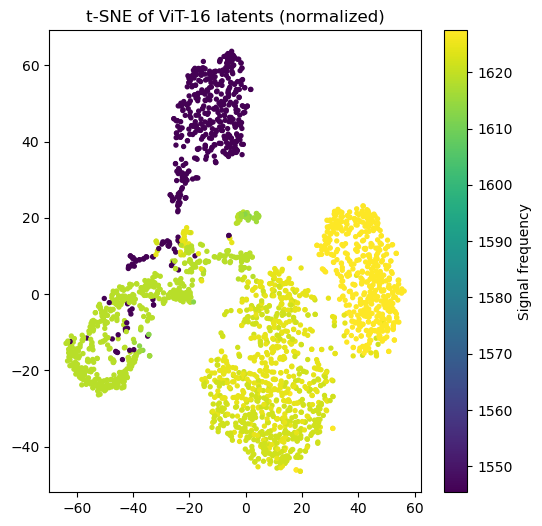

In [16]:
from sklearn.preprocessing import normalize

# Suppose Z_mid, Z_high are your [N×D] ViT outputs
Z_mid_norm  = normalize(latents_32d,  norm="l2", axis=1)

tsne_mid_norm = TSNE(n_components=2, perplexity=30, random_state=42)
Z_tsne_mid_norm = tsne_mid_norm.fit_transform(Z_mid_norm)

plt.figure(figsize=(6,6))
plt.scatter(Z_tsne_mid_norm[:,0], Z_tsne_mid_norm[:,1], c=freqs_array, cmap="viridis", s=8)
plt.colorbar(label="Signal frequency")
plt.title("t-SNE of ViT-16 latents (normalized)")
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

In [17]:
# from sklearn.cluster import DBSCAN, HDBSCAN

# # assume `mus` is your numpy array of shape (N, latent_dim)
# clusterer = HDBSCAN(min_cluster_size=100,
#                             min_samples=50,
#                             metric='cosine',
#                             cluster_selection_method='eom')
# labels = clusterer.fit_predict(latents_32d)   # array of length N: −1 = noise, ≥0 = cluster IDs

# # now you can e.g. visualize
# import matplotlib.pyplot as plt
# plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=labels, cmap="viridis", s=8)
# plt.colorbar(label="Cluster ID")
# plt.title("t-SNE from HDBSCAN")
# # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
# plt.show()


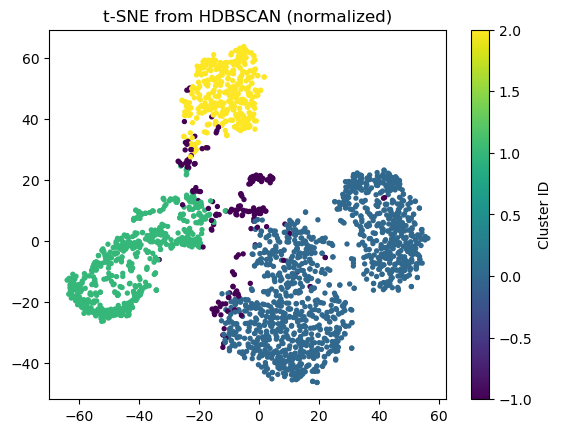

In [18]:
from sklearn.cluster import DBSCAN, HDBSCAN

# assume `mus` is your numpy array of shape (N, latent_dim)
clusterer_mid = HDBSCAN(min_cluster_size=100,
                            min_samples=50,
                            metric='cosine',
                            cluster_selection_method='eom')
labels = clusterer_mid.fit_predict(Z_mid_norm)   # array of length N: −1 = noise, ≥0 = cluster IDs

# now you can e.g. visualize
import matplotlib.pyplot as plt
plt.scatter(Z_tsne_mid_norm[:,0], Z_tsne_mid_norm[:,1], c=labels, cmap="viridis", s=8)
plt.colorbar(label="Cluster ID")
plt.title("t-SNE from HDBSCAN (normalized)")
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

In [19]:
# import random
# from pathlib import Path
# from torchvision import transforms
# from torch.utils.data import DataLoader

# # ─── parameters you can tweak ─────────────────────────────────────────────
# ROOT_DIR     = Path("/datax/scratch/jliang/waterfall_32_pngs")
# NUM_SAMPLES  = 3_000          # absolute count  (set None to use FRACTION)
# FRACTION     = 0.1            # or 10 % of all files
# RNG_SEED     = 42             # so the sample is reproducible
# BATCH_SIZE   = 32
# NUM_WORKERS  = 4
# # ──────────────────────────────────────────────────────────────────────────

# # 1) collect every PNG path once
# all_paths = sorted(ROOT_DIR.rglob("*.png"))
# if not all_paths:
#     raise RuntimeError(f"No PNGs found in {ROOT_DIR}")

# # 2) draw a random sample
# random.seed(RNG_SEED)
# if NUM_SAMPLES is None:
#     NUM_SAMPLES = int(len(all_paths) * FRACTION)

# sampled_32_paths = random.sample(all_paths, k=NUM_SAMPLES)
# print(f"Sampling {NUM_SAMPLES} of {len(all_paths)} images")

# # 3) build the dataset with ONLY those paths
# class WaterfallDataset(torch.utils.data.Dataset):
#     def __init__(self, paths, transform=None):
#         self.paths = paths
#         self.transform = transform or transforms.ToTensor()
#     def __len__(self):
#         return len(self.paths)
#     def __getitem__(self, idx):
#         img = Image.open(self.paths[idx]).convert("L")
#         return self.transform(img), str(self.paths[idx])

# ds = WaterfallDataset(sampled_paths)
# dl = DataLoader(ds, batch_size=BATCH_SIZE,
#                 shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [20]:
# import os
# import re
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torchvision import transforms as T
# from torchvision.models import vit_b_16, ViT_B_16_Weights
# from sklearn.decomposition import PCA

# # ─── CONFIG ───────────────────────────────────────────────────────────────────
# DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE = 64
# MODEL_PATH = None     # if you have a fine-tuned ViT checkpoint, otherwise None
# N_LATENT   = 32       # desired latent dim

# # ─── DATASET & DATALOADER ─────────────────────────────────────────────────────
# # Assume `test_ds` is held-out dataset with:
# #   test_ds.images → list of image paths
# #   test_ds.labels → list of corresponding .txt paths
# # And that `test_ds` applies exactly the transforms below.

# # Use the pretrained ViT’s recommended normalization
# weights   = ViT_B_16_Weights.IMAGENET1K_V1

# vit_preproc = T.Compose([
#     T.Resize(256),
#     T.CenterCrop(224),
#     T.Lambda(lambda img: img.convert("RGB")),  # makes 3-channel PIL
#     T.ToTensor(),
#     T.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std =[0.229, 0.224, 0.225],
#     ),
# ])

# high_res_32_ds = WaterfallDataset(
#     sampled_32_paths,
#     transform=vit_preproc,
# )

# high_res_32_dl = DataLoader(
#     high_res_32_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=2,
#     pin_memory=True
# )

# # ─── BUILD THE ViT ENCODER ────────────────────────────────────────────────────
# backbone = vit_b_16(weights=weights).to(DEVICE)
# # Drop the classification head, leave the CLS embedding
# backbone.heads = nn.Identity()

# # (Optional) load your own checkpoint
# if MODEL_PATH:
#     backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# backbone.eval()

# # ─── EXTRACT ViT FEATURES ─────────────────────────────────────────────────────
# feats_list = []
# with torch.no_grad():
#     for imgs, _ in high_res_32_dl:
#         imgs = imgs.to(DEVICE)
#         # imgs have already been preprocessed by high_res_ds → should match `preproc`
#         # If not, apply: imgs = preproc(imgs)
#         cls_emb = backbone(imgs)            # shape [B, 768]
#         feats_list.append(cls_emb.cpu().numpy())

# features_array = np.vstack(feats_list)   # shape (N_test, 768)

# # ─── REDUCE TO 32-D WITH PCA ───────────────────────────────────────────────────
# pca = PCA(n_components=LATENT_DIM, random_state=42)
# latents_32d_high2 = pca.fit_transform(features_array)  # shape (N_test, 32)


In [21]:
# # ─── EXTRACT FREQUENCIES ───────────────────────────────────────────────────────
# freqs = []
# for path in high_res_32_ds.paths:
#     fname = os.path.basename(path)
#     # adjust the regex to match “f_<number>” in your filenames
#     m = re.search(r"_([0-9\.]+)", fname)
#     freqs.append(float(m.group(1)) if m else np.nan)
# freqs_array_high2 = np.array(freqs)    # shape (N_test,)

# assert latents_32d_high2.shape[0] == freqs_array_high2.shape[0]

In [22]:
# from sklearn.preprocessing import normalize

# # Suppose Z_mid, Z_high are your [N×D] ViT outputs
# Z_high_norm2  = normalize(latents_32d_high2,  norm="l2", axis=1)

# tsne_high_norm2 = TSNE(n_components=2, perplexity=30, random_state=42)
# Z_tsne_high_norm2 = tsne_high_norm2.fit_transform(Z_high_norm2)

# plt.figure(figsize=(6,6))
# plt.scatter(Z_tsne_high_norm2[:,0], Z_tsne_high_norm2[:,1], c=freqs_array_high2, cmap="viridis", s=8)
# plt.colorbar(label="Signal frequency")
# plt.title("t-SNE of ViT-16 latents 1/32 Coarse Channel (normalized)")
# # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
# plt.show()

In [23]:
# from sklearn.cluster import DBSCAN, HDBSCAN

# # assume `mus` is your numpy array of shape (N, latent_dim)
# clusterer_high2 = HDBSCAN(min_cluster_size=20,
#                             min_samples=15,
#                             metric='cosine',
#                             cluster_selection_method='eom')
# labels = clusterer_high2.fit_predict(Z_high_norm2)   # array of length N: −1 = noise, ≥0 = cluster IDs

# # now you can e.g. visualize
# import matplotlib.pyplot as plt
# plt.scatter(Z_tsne_high_norm2[:,0], Z_tsne_high_norm2[:,1], c=labels, cmap="viridis", s=8)
# plt.colorbar(label="Cluster ID")
# plt.title("t-SNE from HDBSCAN (normalized)")
# # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
# plt.show()

In [24]:
import random
from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader

# ─── parameters you can tweak ─────────────────────────────────────────────
ROOT_DIR     = Path("/datax/scratch/jliang/waterfall_pngs")
NUM_SAMPLES  = 3000          # absolute count  (set None to use FRACTION)
FRACTION     = 0.1            # or 10 % of all files
RNG_SEED     = 42             # so the sample is reproducible
BATCH_SIZE   = 32
NUM_WORKERS  = 4
# ──────────────────────────────────────────────────────────────────────────

# 1) collect every PNG path once
all_paths = sorted(ROOT_DIR.rglob("*.png"))
if not all_paths:
    raise RuntimeError(f"No PNGs found in {ROOT_DIR}")

# 2) draw a random sample
random.seed(RNG_SEED)
if NUM_SAMPLES is None:
    NUM_SAMPLES = int(len(all_paths) * FRACTION)

sampled_paths = random.sample(all_paths, k=NUM_SAMPLES)
print(f"Sampling {NUM_SAMPLES} of {len(all_paths)} images")

# 3) build the dataset with ONLY those paths
class WaterfallDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform or transforms.ToTensor()
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("L")
        return self.transform(img), str(self.paths[idx])

# ds = WaterfallDataset(sampled_paths)
# dl = DataLoader(ds, batch_size=BATCH_SIZE,
#                 shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Sampling 3000 of 26989 images


In [54]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.decomposition import PCA

# ─── CONFIG ───────────────────────────────────────────────────────────────────
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MODEL_PATH = None     # if you have a fine-tuned ViT checkpoint, otherwise None
N_LATENT   = 8       # desired latent dim

# ─── DATASET & DATALOADER ─────────────────────────────────────────────────────
# Assume `test_ds` is held-out dataset with:
#   test_ds.images → list of image paths
#   test_ds.labels → list of corresponding .txt paths
# And that `test_ds` applies exactly the transforms below.

# Use the pretrained ViT’s recommended normalization
weights   = ViT_B_16_Weights.IMAGENET1K_V1

vit_preproc = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda img: img.convert("RGB")),  # makes 3-channel PIL
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

high_res_ds = WaterfallDataset(
    sampled_paths,
    transform=vit_preproc,
)

high_res_dl = DataLoader(
    high_res_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ─── BUILD THE ViT ENCODER ────────────────────────────────────────────────────
backbone = vit_b_16(weights=weights).to(DEVICE)
# Drop the classification head, leave the CLS embedding
backbone.heads = nn.Identity()

# (Optional) load your own checkpoint
if MODEL_PATH:
    backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

backbone.eval()

# ─── EXTRACT ViT FEATURES ─────────────────────────────────────────────────────
feats_list = []
with torch.no_grad():
    for imgs, _ in high_res_dl:
        imgs = imgs.to(DEVICE)
        # imgs have already been preprocessed by high_res_ds → should match `preproc`
        # If not, apply: imgs = preproc(imgs)
        cls_emb = backbone(imgs)            # shape [B, 768]
        feats_list.append(cls_emb.cpu().numpy())

features_array = np.vstack(feats_list)   # shape (N_test, 768)

# ─── REDUCE TO 32-D WITH PCA ───────────────────────────────────────────────────
pca = PCA(n_components=LATENT_DIM, random_state=42)
latents_32d_high = pca.fit_transform(features_array)  # shape (N_test, 32)


In [55]:
# ─── EXTRACT FREQUENCIES ───────────────────────────────────────────────────────
freqs = []
for path in high_res_ds.paths:
    fname = os.path.basename(path)
    # adjust the regex to match “f_<number>” in your filenames
    m = re.search(r"_([0-9\.]+)", fname)
    freqs.append(float(m.group(1)) if m else np.nan)
freqs_array_high = np.array(freqs)    # shape (N_test,)

assert latents_32d_high.shape[0] == freqs_array_high.shape[0]

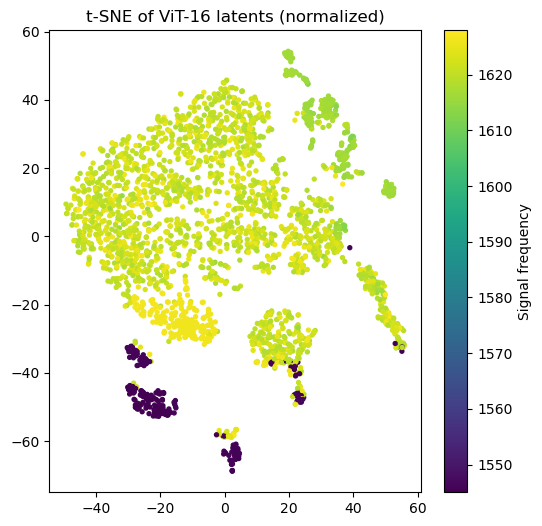

In [27]:
from sklearn.preprocessing import normalize

# Suppose Z_mid, Z_high are your [N×D] ViT outputs
Z_high_norm  = normalize(latents_32d_high,  norm="l2", axis=1)

tsne_high_norm = TSNE(n_components=2, perplexity=30, random_state=42)
Z_tsne_high_norm = tsne_high_norm.fit_transform(Z_high_norm)

plt.figure(figsize=(6,6))
plt.scatter(Z_tsne_high_norm[:,0], Z_tsne_high_norm[:,1], c=freqs_array_high, cmap="viridis", s=8)
plt.colorbar(label="Signal frequency")
plt.title("t-SNE of ViT-16 latents (normalized)")
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

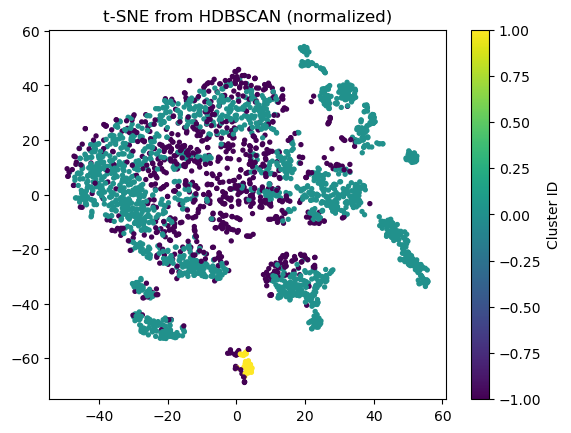

In [28]:
from sklearn.cluster import DBSCAN, HDBSCAN

# assume `mus` is your numpy array of shape (N, latent_dim)
clusterer_high = HDBSCAN(min_cluster_size=20,
                            min_samples=15,
                            metric='cosine',
                            cluster_selection_method='eom')
labels = clusterer_high.fit_predict(Z_high_norm)   # array of length N: −1 = noise, ≥0 = cluster IDs

# now you can e.g. visualize
import matplotlib.pyplot as plt
plt.scatter(Z_tsne_high_norm[:,0], Z_tsne_high_norm[:,1], c=labels, cmap="viridis", s=8)
plt.colorbar(label="Cluster ID")
plt.title("t-SNE from HDBSCAN (normalized)")
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

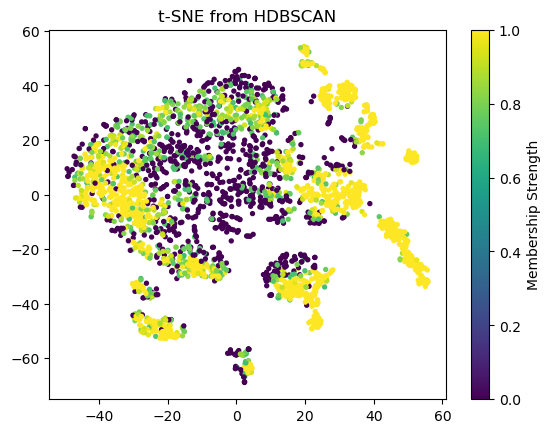

In [29]:
membership_strength = clusterer_high.probabilities_  # float in [0,1] for each sample
plt.scatter(Z_tsne_high_norm[:,0], Z_tsne_high_norm[:,1], c=membership_strength, cmap="viridis", s=8)
plt.colorbar(label="Membership Strength")
plt.title("t-SNE from HDBSCAN")
plt.show()

In [30]:
# import numpy as np
# from scipy.optimize import linear_sum_assignment
# from sklearn.metrics.pairwise import cosine_similarity

# # ───────────────────────────────────────────────────────────────────────
# # INPUTS (you must have these in your namespace)
# # ───────────────────────────────────────────────────────────────────────
# # latents_mid : np.ndarray, shape (N_mid,  d)
# # freqs_mid   : np.ndarray, shape (N_mid,)    in MHz
# # latents_fine: np.ndarray, shape (N_fine, d)
# # freqs_fine  : np.ndarray, shape (N_fine,)  in MHz
# # ───────────────────────────────────────────────────────────────────────

# # 1) Define your frequency windows
# FREQ_WINDOWS = [
#     (1545.0, 1546.0),
#     (1610.0, 1630.0),
#     # add more windows if you like...
# ]

# def assign_freq_cluster(freq, windows=FREQ_WINDOWS):
#     for cid, (lo, hi) in enumerate(windows):
#         if lo <= freq < hi:
#             return cid
#     return -1  # outside any window

# # 2) Bucket each hit by its frequency window
# mid_labels  = np.array([assign_freq_cluster(f) for f in freqs_array])
# fine_labels = np.array([assign_freq_cluster(f) for f in freqs_array_high])

# # 3) List the non‐noise cluster IDs
# mid_cids  = sorted(set(mid_labels)  - {-1})
# fine_cids = sorted(set(fine_labels) - {-1})

# # 4) Compute unit‐length centroids in latent space
# def compute_centroids(latents, labels, cids):
#     C = []
#     for cid in cids:
#         members = latents[labels == cid]
#         ctr = members.mean(axis=0)
#         ctr /= np.linalg.norm(ctr) + 1e-12
#         C.append(ctr)
#     return np.vstack(C)

# mid_C  = compute_centroids(latents_32d,  mid_labels,  mid_cids)
# fine_C = compute_centroids(latents_32d_high, fine_labels, fine_cids)

# # 5) Build the cosine‐similarity matrix
# S = cosine_similarity(mid_C, fine_C)   # shape (len(mid_cids), len(fine_cids))

# # 6) Run the Hungarian algorithm on –S to *maximise* total cosine
# row_ind, col_ind = linear_sum_assignment(-S)

# # 7) Assemble a one‐to‐one mapping (plus similarity)
# mid2fine = {
#     mid_cids[i]: (fine_cids[j], S[i, j])
#     for i, j in zip(row_ind, col_ind)
# }

# # 8) Print out the results
# print("Freq-window clusters → optimal latent-space match:")
# for mid_cid, (fine_cid, sim) in mid2fine.items():
#     lo, hi = FREQ_WINDOWS[mid_cid]
#     print(f"  Mid window {mid_cid} [{lo:.1f}–{hi:.1f}] MHz "
#           f"↔ Fine window {fine_cid} [{FREQ_WINDOWS[fine_cid][0]:.1f}–"
#           f"{FREQ_WINDOWS[fine_cid][1]:.1f}] MHz   cos={sim:.3f}")

# # 9) List any windows that ended up unmatched
# unmatched_mid  = [c for c in mid_cids  if c not in mid2fine]
# unmatched_fine = [c for c in fine_cids if c not in {f for _,(f,_) in mid2fine.items()}]
# print("\nUnmatched mid windows :", unmatched_mid)
# print("Unmatched fine windows:", unmatched_fine)


In [31]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.linalg import orthogonal_procrustes
# from scipy.optimize import linear_sum_assignment

# # ----------------------------------------------------------------------
# # 0) Your separately‐computed PCA reductions (rectangular allowed)
# # ----------------------------------------------------------------------
# mid_red  = latents_32d           # shape (N_mid, d)
# fine_red = latents_32d_high      # shape (N_fine, d)

# # ----------------------------------------------------------------------
# # 1) INITIAL “GREEDY” SEED MATCHING
# #    (we need some equal‐length seed sets to run Procrustes)
# # ----------------------------------------------------------------------
# # full unaligned similarity
# S0 = cosine_similarity(mid_red, fine_red)        # (N_mid × N_fine)

# # for each mid vector i, find best‐matching fine vector j
# best_fine_for_mid = np.argmax(S0, axis=1)         # shape (N_mid,)
# best_sim_for_mid  = np.max (S0, axis=1)           # shape (N_mid,)

# # threshold to keep only high‐confidence seeds
# seed_thr = 0.10
# seed_mid_idx  = np.where(best_sim_for_mid >= seed_thr)[0]
# seed_fine_idx = best_fine_for_mid[seed_mid_idx]

# if len(seed_mid_idx) < mid_red.shape[1]:
#     raise RuntimeError(
#         f"Only {len(seed_mid_idx)} seed pairs (need ≥{mid_red.shape[1]}) — "
#         "lower `seed_thr` or check your data."
#     )

# # ----------------------------------------------------------------------
# # 2) PROCRUSTES ALIGNMENT ON THE SEEDS
# #    solves for R: fine_red[seed] @ R ≈ mid_red[seed]
# # ----------------------------------------------------------------------
# R, _ = orthogonal_procrustes(
#     fine_red[seed_fine_idx],
#     mid_red[ seed_mid_idx ]
# )
# fine_red_aligned = fine_red @ R

# # ----------------------------------------------------------------------
# # 3) FULL COSINE‐SIMILARITY MATRIX
# # ----------------------------------------------------------------------
# S = cosine_similarity(mid_red, fine_red_aligned)  # (N_mid × N_fine)

# # ----------------------------------------------------------------------
# # 4) HUNGARIAN ASSIGNMENT (maximize total cosine)
# # ----------------------------------------------------------------------
# row_ind, col_ind = linear_sum_assignment(-S)      # returns matching of length min(N_mid,N_fine)
# mid2fine = {i: (j, S[i,j]) for i,j in zip(row_ind, col_ind)}

# # (optional) filter out any very weak matches
# THR = 0.0
# mid2fine = {m:(f,s) for m,(f,s) in mid2fine.items() if s>=THR}

# # ----------------------------------------------------------------------
# # 5) REPORT
# # ----------------------------------------------------------------------
# print("Optimal Mid ↔ Fine mapping (Hungarian after Procrustes):")
# for m,(f,s) in sorted(mid2fine.items()):
#     print(f"  Mid {m:>4} ↔ Fine {f:>4}   cos={s:.3f}")

# unmatched_mid  = [i for i in range(mid_red.shape[0]) if i not in mid2fine]
# unmatched_fine = [j for j in range(fine_red.shape[0])
#                   if j not in {f for f,_ in mid2fine.values()}]

# print("\nUnmatched mid vectors :", unmatched_mid)
# print("Unmatched fine vectors:", unmatched_fine)



In [32]:
len(latents_32d), len(freqs_array_high), latents_32d_high.shape, freqs_array_high.shape

(2446, 3000, (3000, 32), (3000,))

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd

# 0) Joint PCA so both clouds share the same basis
d = 8
all_latents = np.vstack([latents_32d, latents_32d_high])   # shape (m+n, D)
pca         = PCA(n_components=d, random_state=0).fit(all_latents)
mid_joint   = pca.transform(latents_32d)                   # (m, d)
fine_joint  = pca.transform(latents_32d_high)              # (n, d)

# 1) Normalize so cosine == dot
mid_norm  = normalize(latents_32d,  axis=1)  # (m, d)
fine_norm = normalize(latents_32d_high, axis=1)  # (n, d)

# 2) Greedy seed matching to get ≥d pairs for Procrustes
S0 = mid_norm @ fine_norm.T                # (m, n)
best_j = np.argmax(S0, axis=1)             # best fine for each mid
best_s = S0[np.arange(len(mid_norm)), best_j]

seed_thr     = 0.20
seed_i       = np.where(best_s >= seed_thr)[0]
if len(seed_i) < d:
    # fallback: take top-d mids by similarity
    seed_i = np.argsort(best_s)[-d:]
seed_j = best_j[seed_i]

# 3) Orthogonal Procrustes on the seeds
R, _          = orthogonal_procrustes(fine_norm[seed_j], mid_norm[seed_i])
fine_aligned  = fine_norm @ R              # (n, d)

# 4) Final cosine matrix after alignment
S = mid_norm @ fine_aligned.T              # (m, n)

import numpy as np
from scipy.optimize import linear_sum_assignment

# S: (m,n) cosine matrix
m, n = S.shape
K = 50

# 1) For each mid‐i, find its top‐K fine indices
topk_fine_for_mid = np.argsort(-S, axis=1)[:, :K]   # shape (m, K)

# 2) For each fine‐j, find its top‐K mid indices
topk_mid_for_fine = np.argsort(-S, axis=0)[:K, :]   # shape (K, n)

# 3) Build the “mutual‐K” candidate list
candidates = []
for i in range(m):
    for j in topk_fine_for_mid[i]:
        # check if i appears in j’s top‐K mids
        if i in topk_mid_for_fine[:, j]:
            candidates.append((i, j))

# 2) Pull out the *unique* mids & fines
mid_cands  = sorted({i for i,j in candidates})
fine_cands = sorted({j for i,j in candidates})

# 3) Build the submatrix S_sub of shape (len(mid_cands), len(fine_cands))
S_sub = S[np.ix_(mid_cands, fine_cands)]

# 4) Run Hungarian on that rectangular matrix
from scipy.optimize import linear_sum_assignment
row_sub, col_sub = linear_sum_assignment(-S_sub)

# 5) Map back to the original indices
row_ind = np.array(mid_cands)[row_sub]
col_ind = np.array(fine_cands)[col_sub]

# 6) Build your DataFrame—now of length = len(row_ind)
df_results = pd.DataFrame({
    'mid_idx':   row_ind,
    'mid_freq':  freqs_array[row_ind],
    'fine_idx':  col_ind,
    'fine_freq': freqs_array_high[col_ind],
    'cosine':    S[row_ind, col_ind],
    'difference': freqs_array[row_ind] - freqs_array_high[col_ind]
})

print(f"{len(df_results)} matches between {len(mid_cands)} mids and {len(fine_cands)} fines")




# # 1) Normalize rows (so dot = cosine)
# mid_norm   = normalize(mid_joint,  axis=1)         # (N_mid, d)
# fine_norm  = normalize(fine_joint, axis=1)         # (N_fine, d)

# # 2) Build full similarity matrix
# S = mid_norm @ fine_norm.T                         # (N_mid, N_fine)

# # 3) Mutual nearest‐neighbor filter
# best_fine_for_mid = np.argmax(S, axis=1)           # shape (N_mid,)
# best_mid_for_fine = np.argmax(S, axis=0)           # shape (N_fine,)

# mutual_pairs = [
#     (i, j, S[i,j])
#     for i in range(S.shape[0])
#     for j in (best_fine_for_mid[i],)
#     if best_mid_for_fine[j] == i
# ]

# print(f"Found {len(mutual_pairs)} mutual‐NN pairs out of {S.shape[0]} mid vectors")

# # 4) (Optional) If you still want a one‐to‐one global assignment, you can
# #    feed only these mutual seeds into Hungarian:
# from scipy.optimize import linear_sum_assignment

# import numpy as np
# import pandas as pd
# from scipy.optimize import linear_sum_assignment

# # — assume you already have:
# #    mid_norm, fine_aligned  # (unit-length) embeddings
# #    freqs_array, freqs_array_high
# #    S = mid_norm @ fine_aligned.T

# # 1) run Hungarian globally
# row_ind, col_ind = linear_sum_assignment(-S)

# # 2) collect all pairs with freqs + cosine
# rows = []
# for m,f in zip(row_ind, col_ind):
#     rows.append({
#         'mid_idx':  m,
#         'mid_freq': freqs_array[m],
#         'fine_idx': f,
#         'fine_freq': freqs_array_high[f],
#         'cosine':   float(S[m,f]),
#         'delta_MHz': freqs_array[m] - freqs_array_high[f]
#     })

# df_matches = pd.DataFrame(rows)

# # 3) prune by cosine threshold (e.g. ≥0.5) and/or Δfreq (e.g. ≤5 MHz)
# df_pruned = df_matches[
#     (df_matches['cosine'] >= 0.5) &
#     (df_matches['delta_MHz'].abs() <= 5)
# ].reset_index(drop=True)

# # 4) save to CSV
# df_pruned.to_csv('hungarian_mid_fine_matches.csv', index=False)

# print(f"Kept {len(df_pruned)} / {len(df_matches)} matches after pruning")
# df_pruned.head()


# seed_row, seed_col, _ = zip(*mutual_pairs)
# S_sub = S[np.ix_(seed_row, seed_col)]
# r, c = linear_sum_assignment(-S_sub)

# hungarian_pairs = [
#     (seed_row[i], seed_col[j], S_sub[i,j])
#     for i,j in zip(r,c)
# ]

# print(f"Hungarian on mutual‐NN seeds yields {len(hungarian_pairs)} pairs")

# # 5) Turn into a CSV
# import pandas as pd
# df = pd.DataFrame(
#     [(i, freqs_array[i], j, freqs_array_high[j], s)
#      for i,j,s in hungarian_pairs],
#     columns=['mid_idx','mid_freq','fine_idx','fine_freq','cosine']
# )
# df.to_csv('mid_fine_matches_pca.csv', index=False)
# print(df.head())


2335 matches between 2390 mids and 2335 fines


In [56]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
fine_red   = latents_32d_high  # shape (n, D)
mid_red    = latents_32d       # shape (m, D)
fine_ids = list(range(fine_red.shape[0]))  # or len(latents_32d_high)
mid_ids  = list(range(mid_red.shape[0]))   # or len(latents_32d)

# ── 0) Shared PCA reduction ────────────────────────────────────────────────
# target_pcs  = 8
# all_latents = np.vstack([latents_32d, latents_32d_high])     # (m+n, D)
# n_samples, n_feats = all_latents.shape
# n_comp     = min(target_pcs, n_feats, n_samples)
# pca        = PCA(n_components=n_comp, random_state=0).fit(all_latents)
# mid_red    = pca.transform(latents_32d)           # (m, k)
# fine_red   = pca.transform(latents_32d_high)      # (n, k)

# ── 1) Normalize so cosine == dot product ─────────────────────────────────
mid_norm   = normalize(mid_red,  axis=1)  # (m, k)
fine_norm  = normalize(fine_red, axis=1)  # (n, k)

# ── 2) Greedy seed matching (fine→mid) ─────────────────────────────────────
#    For each fine vector j, pick its best mid match i
S0                 = mid_norm @ fine_norm.T             # (m, n)
best_mid_for_fine  = np.argmax(S0, axis=0)              # (n,)
best_sim_for_fine  = S0[best_mid_for_fine, np.arange(S0.shape[1])]

# threshold
seed_thr = 0.10
seed_j   = np.where(best_sim_for_fine >= seed_thr)[0]  # fine indices
seed_i   = best_mid_for_fine[seed_j]                   # corresponding mid indices

# ensure ≥k seeds
if len(seed_j) < n_comp:
    top_j   = np.argsort(best_sim_for_fine)[-n_comp:]
    seed_j  = top_j
    seed_i  = best_mid_for_fine[top_j]

# ── 3) Procrustes alignment (fine_norm[seed_j] @ R ≈ mid_norm[seed_i]) ───
R, _         = orthogonal_procrustes(fine_norm[seed_j], mid_norm[seed_i])
fine_aligned = fine_norm @ R                             # (n, k)

# ── 4) Recompute the aligned cosine‐similarity ─────────────────────────────
S = mid_norm @ fine_aligned.T                            # (m, n)

# ── 5) Build the fine→mid mapping ──────────────────────────────────────────
#    For each fine index j, find its best mid index i in the aligned space
best_mid_for_fine_aligned = np.argmax(S, axis=0)         # (n,)
best_sim_for_fine_aligned = S[best_mid_for_fine_aligned, np.arange(S.shape[1])]

fine2mid_aligned = {
    fine_ids[j]: (mid_ids[best_mid_for_fine_aligned[j]],
                  best_sim_for_fine_aligned[j])
    for j in range(len(fine_ids))
}

# ── 6) Report ────────────────────────────────────────────────────────────────
print("Fine -> Mid mapping after Procrustes:")
for f, (m, sim) in fine2mid_aligned.items():
    print(f"  Fine {f:>4} -> Mid {m:>4}   cosine={sim:.3f}")


Fine -> Mid mapping after Procrustes:
  Fine    0 -> Mid   81   cosine=0.544
  Fine    1 -> Mid 2401   cosine=0.755
  Fine    2 -> Mid 1626   cosine=0.655
  Fine    3 -> Mid 1613   cosine=0.697
  Fine    4 -> Mid 1746   cosine=0.715
  Fine    5 -> Mid 1276   cosine=0.844
  Fine    6 -> Mid  691   cosine=0.810
  Fine    7 -> Mid  183   cosine=0.801
  Fine    8 -> Mid 1681   cosine=0.708
  Fine    9 -> Mid  634   cosine=0.721
  Fine   10 -> Mid  225   cosine=0.872
  Fine   11 -> Mid 1058   cosine=0.567
  Fine   12 -> Mid 1296   cosine=0.614
  Fine   13 -> Mid 1302   cosine=0.889
  Fine   14 -> Mid 1687   cosine=0.678
  Fine   15 -> Mid 1179   cosine=0.721
  Fine   16 -> Mid  994   cosine=0.838
  Fine   17 -> Mid  252   cosine=0.712
  Fine   18 -> Mid  124   cosine=0.789
  Fine   19 -> Mid 1022   cosine=0.785
  Fine   20 -> Mid  721   cosine=0.813
  Fine   21 -> Mid  302   cosine=0.580
  Fine   22 -> Mid 1542   cosine=0.766
  Fine   23 -> Mid 1997   cosine=0.792
  Fine   24 -> Mid 1579   

In [34]:
# from scipy.optimize import linear_sum_assignment
# from sklearn.metrics.pairwise import cosine_similarity

# # — assume mid_norm and fine_aligned (after Procrustes) are in scope
# S_full = cosine_similarity(mid_norm, fine_aligned)   # shape (2446, 3000)

# # 1) Straight Hungarian on the full cost
# row_ind, col_ind = linear_sum_assignment(-S_full)

# # 2) Build your DataFrame of all 2446 matches
# import pandas as pd, numpy as np
# df_all = pd.DataFrame({
#     'mid_idx':    row_ind,
#     'mid_freq':   freqs_array[row_ind],
#     'fine_idx':   col_ind,
#     'fine_freq':  freqs_array_high[col_ind],
#     'cosine':     S_full[row_ind, col_ind],
#     'difference': np.abs(freqs_array[row_ind] - freqs_array_high[col_ind])
# })
# print(f"{len(df_all)} total matches (should be 2446)")
# print(df_all.describe())

# weird_all = df_all[df_all['difference'] > 30]
# print(f"{len(weird_all)}/{len(df_all)} rows with |difference|>30 MHz:")
# print(weird_all.head())

In [57]:
import numpy as np
import pandas as pd

# 1) Define your ID lists (here just 0…N-1)
mid_ids  = np.arange(mid_norm.shape[0])
fine_ids = np.arange(fine_norm.shape[0])

# 2) After Procrustes you computed:
#    best_mid_for_fine_aligned  : array of length n, giving the matched mid-index for each fine j
#    best_sim_for_fine_aligned  : array of length n, giving the cosine similarity of that match

# 3) Build the DataFrame
df_matches = pd.DataFrame({
    'fine_idx':   fine_ids,
    'mid_idx':    best_mid_for_fine_aligned,
    'cosine':     best_sim_for_fine_aligned,
})

# 4) (Optional) add frequencies and ΔMHz
df_matches['fine_freq']  = freqs_array_high[df_matches['fine_idx']]
df_matches['mid_freq']   = freqs_array    [df_matches['mid_idx']]
df_matches['difference'] = (df_matches['mid_freq'] - df_matches['fine_freq']).abs()

# 5) Inspect
print(df_matches.head())
# Save if you like:
# df_matches.to_csv('fine_to_mid_matches.csv', index=False)
weird = df_matches[np.abs(df_matches['difference']) > 30]
print(f"{len(weird)}/{len(df_matches)} rows with |difference|>30 MHz:")

   fine_idx  mid_idx    cosine    fine_freq   mid_freq  difference
0         0       81  0.543784  1616.401328  1624.5117    8.110372
1         1     2401  0.755258  1624.058451  1627.4414    3.382949
2         2     1626  0.654686  1615.737822  1545.4102   70.327622
3         3     1613  0.696848  1619.078139  1545.4087   73.669439
4         4     1746  0.714961  1623.461765  1545.4087   78.053065
1345/3000 rows with |difference|>30 MHz:


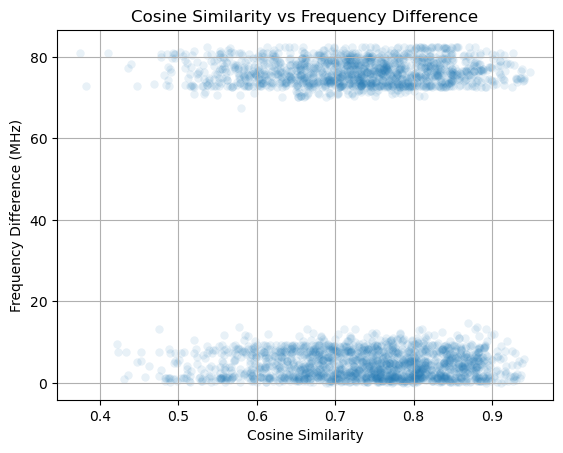

In [58]:
plt.scatter(df_matches['cosine'], df_matches['difference'], alpha=0.1, lw=0)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency Difference (MHz)")
plt.title("Cosine Similarity vs Frequency Difference")
plt.grid()
plt.show()

In [39]:
import pandas as pd

# assume in scope:
#    row_ind, col_ind   # arrays from your Hungarian on the mutual‐KNN candidates
#    S                   # full (m×n) cosine matrix after Procrustes
#    freqs_array         # (m,) mid-res freqs
#    freqs_array_high    # (n,) fine-res freqs

df_results = pd.DataFrame({
    'mid_idx':   row_ind,
    'mid_freq':  freqs_array[row_ind],
    'fine_idx':  col_ind,
    'fine_freq': freqs_array_high[col_ind],
    'cosine':    S[row_ind, col_ind],
    'difference': freqs_array[row_ind] - freqs_array_high[col_ind]
})

# show the top 10 “best” (highest‐cosine) matches
print(df_results.sort_values('cosine', ascending=False).head(10))

# or inspect the “worst” (largest‐difference) ones
print(df_results.reindex(df_results['difference'].abs().sort_values().index).tail(10))


      mid_idx   mid_freq  fine_idx    fine_freq    cosine  difference
1963     2059  1618.6523      2922  1621.660799  0.965764   -3.008499
1797     1877  1618.6523       224  1624.133809  0.957237   -5.481509
54         57  1618.6523       306  1620.156409  0.950011   -1.504109
1541     1609  1618.6523       496  1620.241473  0.949509   -1.589173
649       668  1618.6523      1945  1618.034919  0.940275    0.617381
1112     1147  1618.6523      2008  1619.799840  0.934543   -1.147540
191       199  1618.6523      1321  1618.379893  0.931993    0.272407
386       400  1618.6523      1502  1624.411100  0.927860   -5.758800
813       840  1618.6523      2586  1618.125903  0.926706    0.526397
971      1005  1618.6523       722  1622.913052  0.924071   -4.260752
      mid_idx   mid_freq  fine_idx    fine_freq    cosine  difference
1497     1565  1627.4414      2515  1545.021504  0.755256   82.419896
1518     1586  1627.4414      2346  1545.021490  0.784413   82.419910
755       780  1627.

In [36]:
import pandas as pd

# # build a list of dicts for each matched pair
# rows = []
# for m,(f,s) in mid2fine.items():
#     rows.append({
#         'mid_idx':   m,
#         'mid_freq':  freqs_array[m],
#         'fine_idx':  f,
#         'fine_freq': freqs_array_high[f],
#         'cosine':    s,
#         'difference': freqs_array[m] - freqs_array_high[f]
#     })

# # make a DataFrame and save
# df_matches = pd.DataFrame(rows)
# df_matches.to_csv('mid_fine_cosine_0.2.csv', index=False)

# # optional: peek
# print(df_matches.head())


In [40]:
# df_matches.to_csv('mid_fine_cosine_0.2.csv', index=False)

# optional: peek
print(df_results.head())
weird = df_results[np.abs(df_results['difference']) > 30]
print(f"{len(weird)}/{len(df_results)} rows with |difference|>30 MHz:")
print(weird.head())


   mid_idx   mid_freq  fine_idx    fine_freq    cosine  difference
0        0  1621.5806      2039  1625.160894  0.516269   -3.580294
1        1  1621.5820      1695  1619.355096  0.699346    2.226904
2        2  1624.5117       176  1619.047511  0.447994    5.464189
3        3  1545.4087      1752  1623.053444  0.809391  -77.644744
4        4  1545.4102      2109  1618.089356  0.772640  -72.679156
733/2335 rows with |difference|>30 MHz:
    mid_idx   mid_freq  fine_idx    fine_freq    cosine  difference
3         3  1545.4087      1752  1623.053444  0.809391  -77.644744
4         4  1545.4102      2109  1618.089356  0.772640  -72.679156
5         5  1545.4102       150  1625.687161  0.747410  -80.276961
9         9  1545.4102      2292  1623.869243  0.600608  -78.459043
13       13  1545.4102      1392  1625.902753  0.745202  -80.492553


In [80]:
weird

,mid_idx,mid_freq,fine_idx,fine_freq,cosine,difference
0,3,1545.4087,1752,1623.053444,0.809391,77.644744
1,4,1545.4102,138,1618.453046,0.834119,73.042846
2,5,1545.4102,1036,1623.383382,0.773440,77.973182
6,26,1545.4087,665,1623.650452,0.789954,78.241752
13,132,1545.4102,2210,1618.693993,0.750541,73.283793
16,156,1621.5806,2036,1545.377344,0.815231,76.203256
17,208,1621.5806,219,1545.019884,0.741521,76.560716
20,225,1621.5820,10,1545.980953,0.864034,75.601047
23,278,1621.5820,2979,1545.356437,0.840751,76.225563
27,342,1545.4102,385,1623.081322,0.646802,77.671122


In [ ]:
# 1) create a 'difference' column
df_matches['difference'] = (df_matches['mid_freq'] - df_matches['fine_freq']).abs()

# 2) inspect its distribution
print(df_matches['difference'].describe())


In [ ]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# — assume in scope:
#    S                 # (N_mid, N_fine) full cosine matrix after Procrustes
#    row_ind, col_ind  # arrays of Hungarian‐matched indices
#    freqs_array       # (N_mid,) mid frequencies in MHz
#    freqs_array_high  # (N_fine,) fine frequencies in MHz

# 1) Frequency‐order your axes
mid_sorted  = np.argsort(freqs_array)
fine_sorted = np.argsort(freqs_array_high)

df = pd.DataFrame(S, index=mid_sorted, columns=fine_sorted)

# build maps from original index → position in the sorted DataFrame
pos_mid  = {m:i for i,m in enumerate(mid_sorted)}
pos_fine = {f:j for j,f in enumerate(fine_sorted)}

# 2) Precompute which sorted‐positions have matches
matched_positions = [(pos_mid[m], pos_fine[f]) for m,f in zip(row_ind, col_ind)]

# 3) Labels for ticks
row_labels = [f"{m} ({freqs_array[m]:.1f} MHz)" for m in mid_sorted]
col_labels = [f"{f} ({freqs_array_high[f]:.1f} MHz)" for f in fine_sorted]

# 4) Loop over row‐blocks of size B, but only if there’s at least one match in that block
B = 10
Nmid = df.shape[0]

for start in range(0, Nmid, B):
    end = min(start + B, Nmid)
    # which matched pairs fall into this row‐range?
    block_matches = [(i,j) for (i,j) in matched_positions if start <= i < end]
    if not block_matches:
        continue  # skip empty blocks

    # get the unique fine‐columns for those matches
    cols = sorted({j for (_,j) in block_matches})

    # slice out a (B × len(cols)) sub‐DataFrame
    df_blk = df.iloc[start:end, cols]

    # corresponding labels
    row_lbl_blk = row_labels[start:end]
    col_lbl_blk = [col_labels[j] for j in cols]

    # 5) Plot heatmap for this block
    fig, ax = plt.subplots(
        figsize=(
            max(4, 0.3 * len(cols)),
            max(4, 0.3 * (end - start))
        )
    )
    sns.heatmap(
        df_blk,
        cmap="viridis", vmin=0, vmax=1,
        cbar_kws={'label': 'cosine similarity'},
        linewidths=0.5, linecolor='lightgray',
        ax=ax
    )

    ax.set_xticks(np.arange(len(col_lbl_blk)))
    ax.set_yticks(np.arange(len(row_lbl_blk)))
    ax.set_xticklabels(col_lbl_blk, rotation=45, ha='right', fontsize=6)
    ax.set_yticklabels(row_lbl_blk, rotation=0, ha='right', fontsize=6)

    ax.set_xlabel('Fine vectors (idx | freq)')
    ax.set_ylabel('Mid  vectors (idx | freq)')
    ax.set_title(f'Matched pairs rows {start}–{end-1}')
    plt.tight_layout()
    plt.show()


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# — in scope you have:
#    S                 # (N_mid, N_fine) cosine matrix after Procrustes
#    row_ind, col_ind  # arrays of matched indices
#    freqs_array       # (N_mid,) mid frequencies in MHz
#    freqs_array_high  # (N_fine,) fine frequencies in MHz

# 1) Sort your axes by increasing frequency
mid_sorted  = np.argsort(freqs_array)
fine_sorted = np.argsort(freqs_array_high)

# 2) Build a DataFrame of S with those sorted axes
df = pd.DataFrame(
    S,
    index=mid_sorted,
    columns=fine_sorted
)

# 3) Mask everything *except* the Hungarian matches
#    We need the positions of each (m,f) in the sorted DF:
pos_map_mid  = {m:i for i,m in enumerate(mid_sorted)}
pos_map_fine = {f:j for j,f in enumerate(fine_sorted)}

mask = np.ones(df.shape, dtype=bool)
for m,f in zip(row_ind, col_ind):
    i = pos_map_mid[m]
    j = pos_map_fine[f]
    mask[i,j] = False   # keep only these

# 4) Build nice tick‐labels “idx (freq MHz)”
row_labels = [f"{m} ({freqs_array[m]:.1f} MHz)" for m in mid_sorted]
col_labels = [f"{f} ({freqs_array_high[f]:.1f} MHz)" for f in fine_sorted]

# 5) Plot
fig, ax = plt.subplots(
    figsize=(
      max(4, 0.3 * df.shape[1]),
      max(4, 0.3 * df.shape[0])
    )
)

sns.heatmap(
    df, mask=mask,
    cmap="viridis", vmin=0, vmax=1,
    cbar_kws={'label': 'cosine similarity'},
    linewidths=0.5, linecolor='lightgray',
    ax=ax
)

ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(row_labels, rotation=0, ha='right', fontsize=7)

ax.set_xlabel('Fine vectors (idx | freq MHz)')
ax.set_ylabel('Mid  vectors (idx | freq MHz)')
ax.set_title('Hungarian‐matched pairs only (freq‐ordered)')

plt.tight_layout()
plt.show()


In [ ]:
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt

# # — assume in scope: 
# #    S                 # shape (N_mid, N_fine), your cosine_similarity(mid_red, fine_red_aligned)
# #    freqs_array       # shape (N_mid,), frequency of each mid vector (in MHz)
# #    freqs_array_high  # shape (N_fine,), frequency of each fine vector (in MHz)

# # 1) Get sort‐order by frequency
# mid_idx_sorted  = np.argsort(freqs_array)
# fine_idx_sorted = np.argsort(freqs_array_high)

# # 2) Reorder similarity matrix
# S_ord = S[np.ix_(mid_idx_sorted, fine_idx_sorted)]

# # 3) Build tick labels like "idx (freq MHz)"
# mid_labels  = [f"{i} ({freqs_array[i]:.1f} MHz)"   for i in mid_idx_sorted]
# fine_labels = [f"{j} ({freqs_array_high[j]:.1f} MHz)" for j in fine_idx_sorted]

# # 4) Plot with matplotlib only
# fig, ax = plt.subplots(
#     figsize=(
#       max(4, 0.2 * len(fine_labels)),
#       max(4, 0.2 * len(mid_labels))
#     )
# )

# im = ax.imshow(
#     S_ord,
#     aspect='auto',
#     vmin=0, vmax=1            # fix color scale to [0,1]
# )

# # colorbar
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('cosine similarity')

# # axis ticks
# ax.set_xticks(np.arange(len(fine_labels)))
# ax.set_yticks(np.arange(len(mid_labels)))
# ax.set_xticklabels(fine_labels, rotation=45, ha='right', fontsize=8)
# ax.set_yticklabels(mid_labels, rotation=0, ha='right', fontsize=8)

# ax.set_xlabel('Fine vectors (idx | freq MHz)')
# ax.set_ylabel('Mid  vectors (idx | freq MHz)')
# ax.set_title('Cosine similarity heatmap: mid vs. fine vectors')

# plt.tight_layout()
# plt.savefig('cosine_heatmap.png', dpi=150)
# plt.show()



In [ ]:
from sklearn.preprocessing import normalize
import numpy as np

# (re-normalize so everything is unit-length)
mid_norm = normalize(latents_32d,           axis=1)
fine_norm = normalize(latents_32d_high @ R, axis=1)   # if you’re using your Procrustes R

# dot product of each pair (i↔i)
diag_cos = np.einsum('ij,ij->i', mid_norm, fine_norm)

print("Matched-pair cosine percentiles (0,5,25,50,75,95,100):",
      np.round(np.percentile(diag_cos, [0,5,25,50,75,95,100]), 3))

import matplotlib.pyplot as plt
plt.hist(diag_cos, bins=50)
plt.xlabel("cosine(mid[i], fine[i])")
plt.ylabel("count")
plt.show()


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# in scope:
#   latents_32d, latents_32d_high, R
#   freqs_array, freqs_array_high

# 1) Align + normalize
fine_aligned = latents_32d_high @ R
mid_norm  = normalize(latents_32d,           axis=1)
fine_norm = normalize(fine_aligned,          axis=1)

# 2) Stack & run joint t-SNE
all_latents = np.vstack([mid_norm, fine_norm])
Z = TSNE(n_components=2, init='pca', random_state=0).fit_transform(all_latents)
Z_mid, Z_fine = Z[: len(mid_norm)], Z[len(mid_norm) :]

# 3) Plot
fig, ax = plt.subplots(figsize=(8,6))
# mid-res: circles with white edge
sc1 = ax.scatter(
    Z_mid[:,0], Z_mid[:,1],
    c=freqs_array, cmap='viridis',
    s=20, marker='o', edgecolor='w', linewidth=0.3,
    alpha=0.8, label='mid-res'
)
# fine-res: crosses
sc2 = ax.scatter(
    Z_fine[:,0], Z_fine[:,1],
    c=freqs_array_high, cmap='viridis',
    s=20, marker='x',
    alpha=0.8, label='fine-res'
)

# colorbar (just need one; fine and mid share freq range)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label('Signal frequency (MHz)')

ax.legend(loc='upper left')
ax.set_title('Joint t-SNE of mid vs. fine (after Procrustes)')
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()



In [ ]:
print("Matched mid indices:", row_ind)
print("Matched fine indices:", col_ind)

# Which of those lie in the first block?
print("In block 0–9 → mid:", [i for i in row_ind if 0 <= i < 10])
print("In block 0–9 → fine:",[j for j in col_ind if 0 <= j < 10])


In [ ]:
# # ----------------------------------------------------------------------
# # 0) PCA-BASED LATENT REDUCTION  (unchanged)
# # ----------------------------------------------------------------------
# import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.metrics.pairwise import cosine_similarity

# # target_pcs = 8
# # all_latents = np.vstack([latents_32d, latents_32d_high])
# # n_samples, n_feats = all_latents.shape
# # n_components = min(target_pcs, n_feats, n_samples)

# # pca = PCA(n_components=n_components, random_state=0).fit(all_latents)
# mid_res  = latents_32d
# fine_res = latents_32d_high

# # ----------------------------------------------------------------------
# # 1) CENTROIDS IN PCA SPACE
# # ----------------------------------------------------------------------
# def compute_centroids(lat, labs):
#     cids = sorted(c for c in np.unique(labs) if c != -1)
#     C = []
#     for cid in cids:
#         pts = lat[labs == cid]
#         ctr = pts.mean(axis=0)
#         ctr /= np.linalg.norm(ctr) + 1e-12
#         C.append(ctr)
#     return cids, np.stack(C)

# mid_ids,  mid_C  = compute_centroids(mid_red,  clusterer_mid.labels_)
# fine_ids, fine_C = compute_centroids(fine_red, clusterer_high.labels_)

# # ----------------------------------------------------------------------
# # 2) INITIAL GREEDY MATCH  (for Procrustes seed only)
# # ----------------------------------------------------------------------
# sim0 = cosine_similarity(mid_C, fine_C)
# greedy_mid2fine = {mid_ids[i]: fine_ids[np.argmax(sim0[i])]
#                    for i in range(len(mid_ids))}

# # choose paired rows
# seed_pairs   = [(m, greedy_mid2fine[m]) for m in greedy_mid2fine]
# mid_idx_seed = [mid_ids.index(m)   for m, _ in seed_pairs]
# fine_idx_seed= [fine_ids.index(f)  for _, f in seed_pairs]

# # ----------------------------------------------------------------------
# # 3) PROCRUSTES ALIGNMENT
# # ----------------------------------------------------------------------
# from scipy.linalg import orthogonal_procrustes
# A = mid_C [mid_idx_seed]           # (k,d)
# B = fine_C[fine_idx_seed]          # (k,d)
# R, _ = orthogonal_procrustes(B, A)
# fine_C_aligned = fine_C @ R        # rotate ALL fine centroids

# # ----------------------------------------------------------------------
# # 4) COSINE SIMILARITY AFTER ALIGNMENT
# # ----------------------------------------------------------------------
# S = cosine_similarity(mid_C, fine_C_aligned)   # (M × F)

# # ----------------------------------------------------------------------
# # 5) HUNGARIAN (GLOBAL) ASSIGNMENT
# # ----------------------------------------------------------------------
# from scipy.optimize import linear_sum_assignment

# row_ind, col_ind = linear_sum_assignment(-S)   # maximise total cosine

# mid2fine_opt  = {mid_ids[i]: (fine_ids[j], S[i, j])
#                  for i, j in zip(row_ind, col_ind)}
# fine2mid_opt  = {fine_ids[j]: (mid_ids[i], S[i, j])
#                  for i, j in zip(row_ind, col_ind)}

# # (optional) remove weak links
# THR = 0.30
# mid2fine_opt = {m:(f,s) for m,(f,s) in mid2fine_opt.items() if s >= THR}
# fine2mid_opt = {f:(m,s) for f,(m,s) in fine2mid_opt.items() if s >= THR}

# # ----------------------------------------------------------------------
# # 6) REPORT
# # ----------------------------------------------------------------------
# print("Optimal Mid <-> Fine mapping (Hungarian, Procrustes-aligned)")
# for m,(f,s) in mid2fine_opt.items():
#     print(f"  Mid {m:>3} <-> Fine {f:>3}   cos={s:.3f}")

# unmatched_mid  = [m for m in mid_ids  if m not in mid2fine_opt]
# unmatched_fine = [f for f in fine_ids if f not in fine2mid_opt]

# print("\nUnmatched mid clusters :", unmatched_mid)
# print("Unmatched fine clusters:", unmatched_fine)


In [ ]:
# import numpy as np
# from sklearn.mixture        import GaussianMixture
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.linalg           import orthogonal_procrustes
# from scipy.optimize         import linear_sum_assignment

# # ─── 0) Assume you already have your reduced latents:
# #      mid_red  (N_mid × d), fine_red (N_fine × d)
# # ─────────────────────────────────────────────────────────────────────

# # ─── 1) Choose #components via BIC (optional) ─────────────────────────
# def select_gmm_components(X, min_n=2, max_n=10):
#     bics = []
#     for n in range(min_n, max_n+1):
#         gmm = GaussianMixture(n_components=n,
#                               covariance_type='full',
#                               random_state=0).fit(X)
#         bics.append(gmm.bic(X))
#     best = np.argmin(bics) + min_n
#     return best

# n_mid_best  = select_gmm_components(mid_red,  min_n=2, max_n=5)
# n_fine_best = select_gmm_components(fine_red, min_n=2, max_n=5)
# # n_mid_best  = 2
# # n_fine_best = 2

# print(f"→ Selected mid GMM components:  {n_mid_best}")
# print(f"→ Selected fine GMM components: {n_fine_best}")

# # ─── 2) Fit the two GMMs and get labels ─────────────────────────────────
# gmm_mid  = GaussianMixture(n_components=n_mid_best,
#                            covariance_type='full',
#                            random_state=0).fit(mid_red)
# mid_labels_gmm  = gmm_mid.predict(mid_red)

# gmm_fine = GaussianMixture(n_components=n_fine_best,
#                            covariance_type='full',
#                            random_state=0).fit(fine_red)
# fine_labels_gmm = gmm_fine.predict(fine_red)

# # ─── 3) Compute unit‐length centroids in PCA space ─────────────────────
# def compute_centroids(lat, labs):
#     cids = sorted(c for c in np.unique(labs) if c != -1)
#     C = []
#     for cid in cids:
#         pts = lat[labs == cid]
#         ctr = pts.mean(axis=0)
#         ctr /= np.linalg.norm(ctr) + 1e-12
#         C.append(ctr)
#     return cids, np.stack(C)

# mid_ids,  mid_C  = compute_centroids(mid_red,  mid_labels_gmm)
# fine_ids, fine_C = compute_centroids(fine_red, fine_labels_gmm)

# # ─── 4) Seed Procrustes with greedy cosine matches ──────────────────────
# sim0 = cosine_similarity(mid_C, fine_C)
# greedy_mid2fine = {
#     mid_ids[i]: fine_ids[np.argmax(sim0[i])]
#     for i in range(len(mid_ids))
# }
# seed_pairs   = [(m, greedy_mid2fine[m]) for m in greedy_mid2fine]
# mid_idx_s    = [mid_ids.index(m)   for m,_ in seed_pairs]
# fine_idx_s   = [fine_ids.index(f)  for _,f in seed_pairs]

# A = mid_C[mid_idx_s]
# B = fine_C[fine_idx_s]
# R, _ = orthogonal_procrustes(B, A)
# fine_C_aligned = fine_C @ R

# # ─── 5) Build full cosine‐similarity matrix & do Hungarian ────────────
# S = cosine_similarity(mid_C, fine_C_aligned)    # shape (M × F)
# row_ind, col_ind = linear_sum_assignment(-S)    # maximise total cosine

# mid2fine = {mid_ids[i]: (fine_ids[j], S[i,j]) 
#             for i,j in zip(row_ind, col_ind)}
# fine2mid = {fine_ids[j]: (mid_ids[i], S[i,j]) 
#             for i,j in zip(row_ind, col_ind)}

# # ─── 6) Report ─────────────────────────────────────────────────────────
# print("GMM→Procrustes→Hungarian mapping")
# for m,(f,sim) in mid2fine.items():
#     print(f"  Mid-GMM {m} → Fine-GMM {f}    cos={sim:.3f}")

# # unmatched (if any)
# unmatched_mid  = [m for m in mid_ids  if m not in mid2fine]
# unmatched_fine = [f for f in fine_ids if f not in fine2mid]
# print("Unmatched mid clusters :", unmatched_mid)
# print("Unmatched fine clusters:", unmatched_fine)


In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.optimize import linear_sum_assignment

# # ───────────────────────────────────────────────────────────────────────────
# # Inputs from your GMM pipeline:
# #
# #   mid_labels_gmm   : array of length N_mid
# #   fine_labels_gmm  : array of length N_fine
# #   mid_ids, fine_ids: lists of cluster IDs returned by compute_centroids
# #   S                : numpy array shape (len(mid_ids), len(fine_ids)),
# #                      your aligned cosine_similarity(mid_C, fine_C_aligned)
# #
# #   freqs_array      : numpy array shape (N_mid,), per-hit freq for mid
# #   freqs_array_high : numpy array shape (N_fine,), per-hit freq for fine
# # ───────────────────────────────────────────────────────────────────────────

# # (a) compute centre‐frequency per cluster
# def cluster_cfreq(labels, freqs, cluster_ids):
#     cf = {}
#     for cid in cluster_ids:
#         mask = (labels == cid)
#         if np.any(mask):
#             cf[cid] = freqs[mask].mean()
#         else:
#             cf[cid] = np.nan
#     return cf

# mid_cfreq  = cluster_cfreq(mid_labels_gmm,   freqs_array,      mid_ids)
# fine_cfreq = cluster_cfreq(fine_labels_gmm,  freqs_array_high, fine_ids)

# # (b) build & sort the DataFrame
# df_sim = pd.DataFrame(
#     S,
#     index  = pd.Index(mid_ids,  name="mid"),
#     columns= pd.Index(fine_ids, name="fine")
# )

# # ───────────────────────────────────────────────────────────────────────────
# # (b’)  SORT CLUSTERS BY CENTRE-FREQUENCY
# # ───────────────────────────────────────────────────────────────────────────
# # mid_cfreq and fine_cfreq are your dicts from the GMM cell:
# #    mid_cfreq[cid]  = mean MHz of all mid_latents with label cid
# #    fine_cfreq[cid] = mean MHz of all fine_latents with label cid

# # 1) Build sorted lists of cluster IDs
# mid_sorted  = sorted(mid_ids,  key=lambda cid: mid_cfreq[cid])
# fine_sorted = sorted(fine_ids, key=lambda cid: fine_cfreq[cid])

# # 2) Re-index your similarity DataFrame
# df_sim = pd.DataFrame(
#     S,
#     index  = pd.Index(mid_ids,  name="mid"),
#     columns= pd.Index(fine_ids, name="fine")
# ).loc[mid_sorted, fine_sorted]

# # 3) Recompute the mask
# SIM_THRESH = 0.05
# mask       = df_sim < SIM_THRESH

# # 4) Build new tick labels
# row_labels = [f"{cid} ({mid_cfreq[cid]:.1f} MHz)"   for cid in mid_sorted]
# col_labels = [f"{cid} ({fine_cfreq[cid]:.1f} MHz)" for cid in fine_sorted]


# # (d) plot
# n_mid, n_fine = len(mid_sorted), len(fine_sorted)
# fig_w = max(4, 0.35 * n_fine)
# fig_h = max(4, 0.35 * n_mid)

# plt.figure(figsize=(fig_w, fig_h))
# ax = sns.heatmap(
#     df_sim,
#     mask       = mask,
#     cmap       = "viridis",
#     vmin       = 0, vmax = 1,
#     cbar_kws   = dict(label="Cosine similarity", shrink=.85),
#     annot      = False,
#     linecolor  = "white",
#     linewidths = 0.5
# )
# ax.set_aspect("auto")
# ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=8)
# ax.set_yticklabels(row_labels, rotation=0, ha="right", fontsize=8)

# # (e) annotate only Hungarian pairs
# #    row_ind, col_ind from linear_sum_assignment(-S)
# for m_idx, f_idx in zip(row_ind, col_ind):
#     m_id, f_id = mid_ids[m_idx], fine_ids[f_idx]
#     if m_id in mid_sorted and f_id in fine_sorted:
#         r = mid_sorted.index(m_id)
#         c = fine_sorted.index(f_id)
#         sim_val = df_sim.iat[r, c]
#         if sim_val >= SIM_THRESH:
#             ax.text(
#                 c+0.5, r+0.5,
#                 f"{sim_val:.2f}",
#                 ha="center", va="center",
#                 color="black", fontsize=7
#             )

# plt.xlabel("Fine-GMM clusters  (ID • centre-freq)")
# plt.ylabel("Mid-GMM clusters   (ID • centre-freq)")
# plt.title("Aligned cosine similarity   —   Mid-GMM vs Fine-GMM")
# plt.tight_layout()
# plt.show()



In [ ]:
# ======================================================================
# 7)  HEAT-MAP OF MID × FINE CLUSTERS  (frequency-ordered)
# ======================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------------
# (a)  Build centre-frequency dictionaries if you have them already.
#      Here we compute them as the mean of member frequencies.
#      Replace this with your own arrays if available.
# ------------------------------------------------------------------
# freqs_mid  : np.ndarray shape (N_mid,)   (MHz for every latent x_i)
# freqs_fine : np.ndarray shape (N_fine,)  (MHz for every latent y_j)

def cluster_cfreq(labels, freqs):
    return {cid: freqs[labels == cid].mean()
            for cid in np.unique(labels) if cid != -1}

mid_cfreq  = cluster_cfreq(clusterer_mid.labels_,   freqs_array)
fine_cfreq = cluster_cfreq(clusterer_high.labels_,  freqs_array_high)

# ------------------------------------------------------------------
# (b)  Put similarity matrix in a DataFrame and sort by frequency
# ------------------------------------------------------------------
df_sim = pd.DataFrame(
    S,                                   # S from Step-4 (after Procrustes)
    index=pd.Index(mid_ids,  name="mid"),
    columns=pd.Index(fine_ids, name="fine")
)

mid_sorted  = sorted(mid_ids,  key=lambda i: mid_cfreq[i])
fine_sorted = sorted(fine_ids, key=lambda j: fine_cfreq[j])
df_sim = df_sim.loc[mid_sorted, fine_sorted]

# mask tiny values for clarity
SIM_THRESH = 0.05
mask = df_sim < SIM_THRESH

# ------------------------------------------------------------------
# (c)  Prepare tick labels “ID  (freq MHz)”
# ------------------------------------------------------------------
row_labels = [f"{cid} ({mid_cfreq[cid]:.1f})"  for cid in mid_sorted]
col_labels = [f"{cid} ({fine_cfreq[cid]:.1f})" for cid in fine_sorted]

# ------------------------------------------------------------------
# PLOT — auto aspect and dynamic figsize
# ------------------------------------------------------------------
n_mid, n_fine = len(mid_sorted), len(fine_sorted)

# choose 0.35 in of width per column, 0.35 in of height per row
fig_w = max(4, 0.35 * n_fine)   # at least 4 inches
fig_h = max(4, 0.35 * n_mid)

plt.figure(figsize=(fig_w, fig_h))
ax = sns.heatmap(
    df_sim,
    mask       = mask,
    cmap       = "viridis",
    vmin       = 0, vmax = 1,
    cbar_kws   = dict(label="cosine similarity", shrink=.85),
    annot      = False,
    linecolor  = "white", linewidths=0.5
)

# allow rectangular cells
ax.set_aspect("auto")           

# nicer tick labels
ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(row_labels, rotation=0,  ha="right", fontsize=8)

# annotate only Hungarian pairs
for m_idx, f_idx in zip(row_ind, col_ind):
    m_id, f_id = mid_ids[m_idx], fine_ids[f_idx]
    if m_id in mid_sorted and f_id in fine_sorted:
        r = mid_sorted.index(m_id)
        c = fine_sorted.index(f_id)
        sim_val = df_sim.iat[r, c]
        ax.text(c + 0.5, r + 0.5, f"{sim_val:.2f}",
                    color="black", ha="center", va="center", fontsize=7)

plt.xlabel("Fine clusters  (ID | centre-freq MHz)")
plt.ylabel("Mid clusters   (ID | centre-freq MHz)")
plt.title("Aligned cosine similarity   |   Mid vs. Fine cluster map")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
mask = labels!=-1
sil = silhouette_score(fine_red[mask], labels[mask], metric='cosine')
print("Fine‐res silhouette:", sil)



In [ ]:
from sklearn.metrics import silhouette_score
mask = labels!=-1
sil = silhouette_score(fine_red[mask], labels[mask], metric='cosine')
print("Fine‐res silhouette:", sil)

In [ ]:
# REDUCING LATENT SPACE TO 8 DIMENSIONS USING PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# 1) Choose PCA dimension (e.g. 8) but cap at available rank
# target_pcs = 8
# all_latents = np.vstack([latents_32d, latents_32d_high])
# n_samples, n_feats = all_latents.shape
# n_components = min(target_pcs, n_feats, n_samples)

# # 2) Fit PCA on the *combined* set
# pca = PCA(n_components=n_components, random_state=0)
# pca.fit(all_latents)

# 3) Transform mid & fine latents into the shared PCA space
mid_red  = latents_32d   # shape (N_mid,  n_components)
fine_red = latents_32d_high  # shape (N_fine, n_components)

# 4) Compute cluster centroids in that PCA space
def compute_centroids(lat, labs):
    cids = sorted(c for c in np.unique(labs) if c != -1)
    C = []
    for cid in cids:
        pts = lat[labs == cid]
        ctr = pts.mean(axis=0)
        ctr /= np.linalg.norm(ctr) + 1e-12
        C.append(ctr)
    return cids, np.stack(C, axis=0)

mid_ids,  mid_C  = compute_centroids(mid_red,  clusterer_mid.labels_)
fine_ids, fine_C = compute_centroids(fine_red, clusterer_high.labels_)

# 5) Cosine‐similarity matrix in PCA space
sim_mat = cosine_similarity(mid_C, fine_C)

# 6) Best matches in both directions
best_mid2fine = {
    mid_ids[i]: (fine_ids[j], sim_mat[i, j])
    for i, j in enumerate(np.argmax(sim_mat, axis=1))
}
best_fine2mid = {
    fine_ids[j]: (mid_ids[i], sim_mat[i, j])
    for j, i in enumerate(np.argmax(sim_mat, axis=0))
}

from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ─── 1) build parallel arrays of matched centroids ─────────────────────────
matched = [(mid, fine) for mid,(fine,_) in best_mid2fine.items()]
mid_match_ids, fine_match_ids = zip(*matched)

# find their row‐indices in mid_C / fine_C
mid_idx  = [mid_ids.index(mid)  for mid in mid_match_ids]
fine_idx = [fine_ids.index(fine) for fine in fine_match_ids]

A = mid_C[mid_idx]    # shape (k, d)
B = fine_C[fine_idx]  # shape (k, d)

# ─── 2) solve for the best orthogonal rotation R so that B @ R ≈ A ────
R, scale = orthogonal_procrustes(B, A)

# ─── 3) apply that rotation to ALL fine centroids ───────────────────────
fine_C_aligned = fine_C.dot(R)   # now aligned to mid‐space

# ─── 4) re‐compute cosine similarities in the aligned space ────────────
sim_aligned = cosine_similarity(mid_C, fine_C_aligned)

# ─── 5) get new best matches Mid→Fine & Fine→Mid ────────────────────────
best_mid2fine_aligned = {
    mid_ids[i]: (fine_ids[j], sim_aligned[i, j])
    for i, j in enumerate(np.argmax(sim_aligned, axis=1))
}
best_fine2mid_aligned = {
    fine_ids[j]: (mid_ids[i], sim_aligned[i, j])
    for j, i in enumerate(np.argmax(sim_aligned, axis=0))
}

# ─── 6) report ───────────────────────────────────────────────────────────
print("After Procrustes alignment:")
print("\nMid -> Fine:")
for m,(f,sim) in best_mid2fine_aligned.items():
    print(f"  Mid {m} -> Fine {f}   cosine={sim:.3f}")

print("\nFine -> Mid:")
for f,(m,sim) in best_fine2mid_aligned.items():
    print(f"  Fine {f} -> Mid {m}   cosine={sim:.3f}")

# # ─── Report ────────────────────────────────────────────────────────────────
# print("Mid → Fine (in PCA space):")
# for m, (f, s) in best_mid2fine.items():
#     print(f"  Mid #{m} → Fine #{f}   cosine={s:.3f}")

# print("\nFine → Mid (in PCA space):")
# for f, (m, s) in best_fine2mid.items():
#     print(f"  Fine #{f} → Mid #{m}   cosine={s:.3f}")


In [ ]:
mid_latents = latents_32d
fine_latents = latents_32d_high
mid_labels = clusterer_mid.labels_
fine_labels = clusterer_high.labels_

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ─── your inputs ─────────────────────────────────────────────────────────
# mid_latents   : np.ndarray, shape (N_mid,  D)
# mid_labels    : np.ndarray, shape (N_mid,)
# fine_latents  : np.ndarray, shape (N_fine, D)
# fine_labels   : np.ndarray, shape (N_fine,)
# best_mid2fine_aligned : dict[mid_cid] -> (fine_cid, similarity)
#                                                                             

# sanity‐check
assert mid_latents.shape[0] == mid_labels.shape[0]
assert fine_latents.shape[0] == fine_labels.shape[0]

# ─── 1) run t-SNE on the combined set ───────────────────────────────────────
all_latents = np.vstack([mid_latents, fine_latents])
n = all_latents.shape[0]
perp = min(30, max(2, n // 3))   # ensure 2 ≤ perplexity < n

tsne = TSNE(
    n_components    = 2,
    perplexity      = perp,
    init            = 'pca',
    learning_rate   = 'auto',
    random_state    = 0,
)
all_xy = tsne.fit_transform(all_latents)

mid_xy  = all_xy[: mid_latents.shape[0], :]
fine_xy = all_xy[mid_latents.shape[0]:, :]

# ─── 2) plot the point clouds ───────────────────────────────────────────────
plt.figure(figsize=(10,10))

# mid-res (circles)
plt.scatter(
    mid_xy[:,0], mid_xy[:,1],
    c=mid_labels,
    cmap='tab20',
    marker='o',
    s=30,
    alpha=0.6,
    label='mid-res'
)

# fine-res (squares)
plt.scatter(
    fine_xy[:,0], fine_xy[:,1],
    c=fine_labels,
    cmap='tab20',
    marker='s',
    s=30,
    alpha=0.6,
    label='fine-res'
)

cb = plt.colorbar(ticks=np.unique(mid_labels))
cb.set_label("Cluster ID")

# ─── 3) compute 2D centroids & draw match lines ─────────────────────────────
# build centroid coords for each cluster ID
mid_centroid_2d = { cid: mid_xy[mid_labels==cid].mean(axis=0)
                    for cid in np.unique(mid_labels) if cid != -1 }
fine_centroid_2d= { cid: fine_xy[fine_labels==cid].mean(axis=0)
                    for cid in np.unique(fine_labels) if cid != -1 }

for mid_cid, (fine_cid, sim) in best_mid2fine_aligned.items():
    if mid_cid in mid_centroid_2d and fine_cid in fine_centroid_2d:
        x0,y0 = mid_centroid_2d[mid_cid]
        x1,y1 = fine_centroid_2d[fine_cid]
        plt.plot([x0,x1],[y0,y1], '-k', alpha=0.4, linewidth=1)
        # optional: annotate sim at midpoint
        plt.text((x0+x1)/2, (y0+y1)/2,
                 f"{sim:.2f}",
                 color='k', fontsize=7, ha='center', va='center')

plt.legend()
plt.title(f"t-SNE of Mid/Fine latents (perplexity={perp})")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# … after you have mid_C and fine_C_aligned from Procrustes …

# 1) stack centroids
all_centroids = np.vstack([mid_C, fine_C_aligned])
n_samples = all_centroids.shape[0]

# 2) choose a valid perplexity: < n_samples, and at least 2
perplexity = min(30, n_samples - 1)
if perplexity < 2:
    raise ValueError(f"Not enough centroids ({n_samples}) for TSNE.")

# 3) run TSNE
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate='auto',
    init='pca',
    random_state=0,
)
coords2d = tsne.fit_transform(all_centroids)

# 4) split back out
mid_xy  = coords2d[: len(mid_C)]
fine_xy = coords2d[len(mid_C):]

# 5) plot
plt.figure(figsize=(8,8))
plt.scatter(mid_xy[:,0],  mid_xy[:,1],  c='C0', s=100, label='Mid centroids')
plt.scatter(fine_xy[:,0], fine_xy[:,1], c='C1', s=100, marker='s', label='Fine centroids')

for mid_cid, (fine_cid, sim) in best_mid2fine_aligned.items():
    i = mid_ids.index(mid_cid)
    j = fine_ids.index(fine_cid)
    x0,y0 = mid_xy[i]
    x1,y1 = fine_xy[j]
    plt.plot([x0,x1], [y0,y1], '-k', alpha=0.4)
    plt.text((x0+x1)/2, (y0+y1)/2, f"{sim:.2f}",
             color='gray', fontsize=8, ha='center', va='center')

# annotate
for i, cid in enumerate(mid_ids):
    plt.text(mid_xy[i,0], mid_xy[i,1], str(cid),
             fontsize=9, weight='bold', ha='right', va='bottom')
for j, cid in enumerate(fine_ids):
    plt.text(fine_xy[j,0], fine_xy[j,1], str(cid),
             fontsize=9, weight='bold', ha='left',  va='top')

plt.legend()
plt.title("t-SNE of Mid vs Fine centroids (perplexity={} )".format(perplexity))
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_centroids(latents: np.ndarray,
                      labels: np.ndarray) -> tuple[list, np.ndarray]:
    """
    Compute L2‐normalised centroids for each cluster (label != -1).
    Returns:
      cluster_ids : sorted list of cluster labels
      C           : array of shape (n_clusters, dim)
    """
    cluster_ids = sorted(l for l in np.unique(labels) if l != -1)
    centroids = []
    for cid in cluster_ids:
        members = latents[labels == cid]
        ctr = members.mean(axis=0)
        ctr /= np.linalg.norm(ctr)          # normalise the mean
        centroids.append(ctr)
    return cluster_ids, np.stack(centroids, axis=0)

# ─── assume these exist: mid_latents, mid_labels, fine_latents, fine_labels ───

mid_ids,  mid_C  = compute_centroids(latents_32d, clusterer_mid.labels_)
fine_ids, fine_C = compute_centroids(latents_32d_high, clusterer_high.labels_)

# ─── cosine‐similarity matrix (mid × fine) ───────────────────────────────────
sim_mat = cosine_similarity(mid_C, fine_C)
# sim_mat[i,j] = cos_sim(mid_ids[i] centroid, fine_ids[j] centroid)

# 1) Mid→Fine (best fine cluster for each mid cluster)
row_max = np.argmax(sim_mat, axis=1)   # for each mid‐row, index of best fine‐col
best_mid2fine = {
    mid_ids[i]: (fine_ids[j], sim_mat[i, j])
    for i, j in enumerate(row_max)
}

# 2) Fine→Mid (best mid cluster for each fine cluster)
col_max = np.argmax(sim_mat, axis=0)   # for each fine‐col, index of best mid‐row
best_fine2mid = {
    fine_ids[j]: (mid_ids[i], sim_mat[i, j])
    for j, i in enumerate(col_max)
}

# 3) Print mappings
print("Mid -> Fine:")
for mid_cid, (fine_cid, sim) in best_mid2fine.items():
    print(f"  Mid {mid_cid} -> Fine {fine_cid}   (cosine={sim:.3f})")

print("\nFine -> Mid:")
for fine_cid, (mid_cid, sim) in best_fine2mid.items():
    print(f"  Fine {fine_cid} -> Mid {mid_cid}   (cosine={sim:.3f})")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_hex
from PIL import Image, ImageDraw
import random

# assume:
#   labels      — your HDBSCAN cluster labels, shape (N,)
#   dataset     — your YoloMaskDataset (with .images and .labels lists)
#   Z_tsne      — your t-SNE coords, shape (N,2)

# 1) Pick a discrete colormap (tab20 has 20 distinct colors)
unique_labels = np.unique(labels)
# remove noise if you like, or keep it
# unique_labels = unique_labels[unique_labels>=0]

# make a colormap with as many entries as distinct clusters
cmap = cm.get_cmap('tab20', len(unique_labels))

# map each cluster ID → a hex color
label2color = {}
for idx, lab in enumerate(unique_labels):
    # if lab == -1:
    #     label2color[lab] = "#808080"           # gray for noise
    # else:
        rgba               = cmap(idx)        # RGBA tuple in [0,1]
        label2color[lab]   = to_hex(rgba)     # convert to "#rrggbb"

# 2) (Optional) re‐plot your TSNE with the same discrete colors so you can check
plt.figure(figsize=(6,6))
for lab in unique_labels:
    mask = labels == lab
    plt.scatter(
        Z_tsne_high_norm[mask,0],
        Z_tsne_high_norm[mask,1],
        c=label2color[lab],
        label=f"{lab}",
        s=8,
        linewidths=0
    )
plt.legend(title="Cluster")
plt.title("t-SNE of VAE latents (discrete colors)")
plt.show()



In [ ]:
import os, math, re, itertools, colorsys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

# ─── CONFIG ───────────────────────────────────────────────────────────────
ROOT_DIR   = Path("/datax/scratch/jliang/waterfall_pngs")
COLS, ROWS = 6, 6
PER_PAGE   = COLS * ROWS
OUT_PDF    = "waterfalls_by_cluster_viridis.pdf"
TILE_SIZE_IN = 2.5                     # inches per tile edge
# ──────────────────────────────────────────────────────────────────────────

# 0) labels must be provided (same order as paths)
#    e.g. labels = np.load("cluster_labels.npy")
labels = clusterer_high.labels_                            # ← your 1-D array (N,)
# -------------------------------------------------------------------------

# 1) collect paths and sanity-check length
paths = sampled_paths
if len(paths) != len(labels):
    raise ValueError(f"{len(paths)=} does not match {len(labels)=}")

paths = np.array(paths)
labels = np.asarray(labels)
unique_labels = np.unique(labels)

# 2) deterministic colour map: distinct hue per cluster id
def label2color(lab):
    if lab < 0:                     # noise
        return "#808080"
    hue = (lab * 0.6180339887) % 1  # golden-ratio hop around HSV wheel
    r, g, b = colorsys.hsv_to_rgb(hue, 0.8, 0.9)
    return (r, g, b)

# 3) regex to extract freq min/max
freq_pat = re.compile(r"_(\d+\.\d+)-(\d+\.\d+)")

with PdfPages(OUT_PDF) as pdf:
    for lab in unique_labels:
        idxs = np.where(labels == lab)[0]
        if idxs.size == 0:
            continue

        n_pages = math.ceil(idxs.size / PER_PAGE)
        for p in range(n_pages):
            page_slice = idxs[p * PER_PAGE : (p + 1) * PER_PAGE]

            fig, axes = plt.subplots(ROWS, COLS,
                                     figsize=(COLS * TILE_SIZE_IN,
                                              ROWS * TILE_SIZE_IN))
            fig.suptitle(f"Cluster {lab} — page {p+1}/{n_pages}",
                         fontsize=16, weight="bold",
                         color=label2color(lab))

            for ax, idx in zip(axes.flatten(), page_slice):
                img_path = paths[idx]
                img      = Image.open(img_path).convert("L")
                ax.imshow(img, cmap="viridis", origin="lower", interpolation="none")
                ax.axis("off")

                # coloured frame
                for spine in ax.spines.values():
                    spine.set_color(label2color(lab))
                    spine.set_linewidth(2)

                # title = centre freq ± half-span
                m = freq_pat.search(img_path.name)
                if m:
                    f_min, f_max = map(float, m.groups())
                    f_cen  = 0.5 * (f_min + f_max)
                    span   = f_max - f_min
                    text   = f"{f_cen:.3f} MHz\n±{span/2:.3f}"
                else:
                    text   = img_path.stem

                ax.set_title(text, fontsize=8, weight="bold")

            # blank unused tiles on final page
            for ax in axes.flatten()[len(page_slice):]:
                ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig)
            plt.close(fig)

print(f"✓ Saved {OUT_PDF} ({len(paths)} images, {len(unique_labels)} clusters)")




In [ ]:
# import math
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from PIL import Image

# # ─── CONFIG ────────────────────────────────────────────────────────────────────
# cols = 6
# rows = 6
# per_page   = cols * rows
# out_pdf    = "all_crops_by_cluster_i_s154_with_deltas_vit_100_highres.pdf"

# # total time span of each spectrogram (in seconds)
# time_window_seconds = 5*60

# # assume these are defined:
# #  • labels, val_ds.images, val_ds.labels, label2color

# unique_labels = sorted(set(labels.tolist()))

# with PdfPages(out_pdf) as pdf:
#     for lab in unique_labels:
#         idxs = np.where(labels == lab)[0]
#         if len(idxs) == 0:
#             continue

#         n_pages = math.ceil(len(idxs) / per_page)
#         for p in range(n_pages):
#             start     = p * per_page
#             page_idxs = idxs[start : start + per_page]

#             fig, axes = plt.subplots(rows, cols,
#                                      figsize=(cols * 2.5, rows * 2.5))
#             fig.suptitle(f"Cluster {lab} — page {p+1}/{n_pages}", 
#                          fontsize=16)

#             for ax, idx in zip(axes.flatten(), page_idxs):
#                 # load crop → PIL
#                 img = Image.open(test_ds.images[idx]).convert("L")

#                 # read the single YOLO box
#                 lbl_path = test_ds.labels[idx]
#                 with open(lbl_path) as f:
#                     cls, xc, yc, w_norm, h_norm = map(float, f.readline().split())

#                 # — pull per-image freq_min / freq_max from the filename —
#                 fname = os.path.basename(test_ds.images[idx])
#                 m = re.search(r"f_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)", fname)
#                 if not m:
#                     raise ValueError(f"Could not parse freq range from {fname}")
#                 freq_max_img = float(m.group(1))
#                 freq_min_img = float(m.group(2))
#                 freq_range_img = freq_max_img - freq_min_img

#                 # compute physical sizes
#                 time_size = h_norm * time_window_seconds    # seconds
#                 freq_size = w_norm * freq_range_img  # MHz

#                 # draw image and colored frame
#                 ax.imshow(img)
#                 ax.axis("off")
#                 for spine in ax.spines.values():
#                     spine.set_edgecolor(label2color.get(lab, "#000000"))
#                     spine.set_linewidth(2)

#                 # set title to include t and f
#                 ax.set_title(
#                     f"C{lab} | t={time_size:.1f}s | f={freq_size:.1f}MHz\n C={freq_min_img + freq_range_img * xc:.1f}MHz",
#                     color='k',
#                     weight='bold',
#                     fontsize=10,
#                 )

#             # blank out unused axes
#             for ax in axes.flatten()[len(page_idxs):]:
#                 ax.axis("off")

#             plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#             pdf.savefig(fig)
#             plt.close(fig)

# print(f"Saved PDF with per box t/f annotations to {out_pdf}")


In [ ]:
# import math
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from PIL import Image

# # 1) Make sure you have these in your environment:
# #    • labels:     numpy array of length N with cluster IDs (-1 for noise)
# #    • full_ds:    your dataset, so that full_ds[i] returns (crop_tensor, …)
# #    • label2color: dict mapping each cluster ID → hex color (e.g. "#1f77b4")

# # 2) Derive unique cluster IDs
# unique_labels = sorted(set(labels.tolist()))

# # 3) Grid dimensions
# cols = 6
# rows = 6
# per_page = cols * rows
# out_pdf = "all_crops_by_cluster_i_s154.pdf"

# with PdfPages(out_pdf) as pdf:
#     for lab in unique_labels:
#         # if lab == -1:
#         #     continue  # skip noise if you’d like

#         idxs = np.where(labels == lab)[0]
#         # if len(idxs) == 0:
#         #     continue

#         n_pages = math.ceil(len(idxs) / per_page)
#         for p in range(n_pages):
#             start = p * per_page
#             end   = start + per_page
#             page_idxs = idxs[start:end]

#             fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
#             fig.suptitle(f"Cluster {lab} — page {p+1}/{n_pages}", fontsize=16)

#             for ax, idx in zip(axes.flatten(), page_idxs):
#                 # grab the crop tensor and convert to PIL
#                 crop_tensor = val_ds[idx][0]
#                 arr = crop_tensor.permute(1,2,0).cpu().numpy()
#                 arr = (arr * 255).astype(np.uint8)
#                 img = Image.fromarray(arr)

#                 ax.imshow(img)
#                 ax.axis("off")

#                 # color the frame to match cluster
#                 for spine in ax.spines.values():
#                     spine.set_edgecolor(label2color.get(lab, "#000000"))
#                     spine.set_linewidth(2)
#                 ax.set_title(f"C{lab}", color=label2color.get(lab, "#000000"), fontsize=8)

#             # blank out unused subplots
#             for ax in axes.flatten()[len(page_idxs):]:
#                 ax.axis("off")

#             plt.tight_layout(rect=[0,0.03,1,0.95])
#             pdf.savefig(fig)
#             plt.close(fig)

# print(f"▶️ Saved all crops to {out_pdf}")




In [ ]:
# %pip install seaborn
# import seaborn as sns
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report

# # ─── assume these are already in your namespace ────────────────────────────────
# # labels      : np.ndarray of shape (N,) with HDBSCAN cluster IDs (−1=noise)
# # freqs_array : np.ndarray of shape (N,) with the extracted f_… values

# # 1) (Optional) ignore noise points
# mask        = labels >= 0
# labels_filt = labels[mask]
# freqs_filt  = freqs_array[mask]

# # 2) Build true frequency‐based classes
# #    class 1 = in 1610–1620 MHz, else class 0 (i.e., ~1545 MHz)
# true_classes = np.where(
#     (freqs_filt >= 1610) & (freqs_filt <= 1620),
#     1,
#     0
# )

# # 3) Map each cluster ID to the class whose mean freq it sits in
# cluster_ids    = np.unique(labels_filt)
# cluster_means  = {cid: freqs_filt[labels_filt == cid].mean()
#                   for cid in cluster_ids}

# cluster_to_cls = {}
# for cid, mean_f in cluster_means.items():
#     if 1610 <= mean_f <= 1620:
#         cluster_to_cls[cid] = 1
#     else:
#         cluster_to_cls[cid] = 0

# # 4) Build predicted classes from cluster assignments
# pred_classes = np.array([cluster_to_cls[c] for c in labels_filt])

# # 5) Compute & print the confusion matrix
# cm = confusion_matrix(true_classes, pred_classes, labels=[0,1])
# print("Confusion matrix (rows=true, cols=predicted):")
# print(cm)

# # 6) (Optional) More detailed metrics
# print("\nClassification report:")
# print(classification_report(true_classes, pred_classes, target_names=[
#     "1545 MHz",
#     "1610-1620 MHz"
# ]))

# # 1) Compute the 2×2 matrix
# cm = confusion_matrix(true_classes, pred_classes, labels=[0, 1])

# # 2) Plot with Seaborn
# plt.figure(figsize=(6, 5))
# ax = sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=["1545 MHz", "1610-1620 MHz"],
#     yticklabels=["1545 MHz", "1610-1620 MHz"]
# )
# ax.set_xlabel("Predicted Class")
# ax.set_ylabel("True Class")
# ax.set_title("Confusion Matrix: Frequency-Based Clustering")

# plt.tight_layout()
# plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

CLS_1610 = 0          # 1610–1620 MHz   (positive)
CLS_1545 = 1          # 1545 MHz band   (positive)
CLS_NA   = -1         # everything else (ignored)

# ─── true classes (only two bands) ────────────────────────────────────────
true2 = np.full(freqs_array_high.shape, CLS_NA, dtype=int)
true2[(1545  <= freqs_array_high) & (freqs_array_high < 1546)] = CLS_1545
true2[(1610  <= freqs_array_high) & (freqs_array_high <= 1620)] = CLS_1610

# ─── map each cluster to 0 / 1 / -1 (unmapped ⇒ -1) ───────────────────────
cluster_means = {cid: freqs_array_high[labels == cid].mean()
                 for cid in np.unique(labels)}

cluster_to_cls2 = {}
tol = 1.0            # MHz tolerance for the narrow 1545 band
for cid, f in cluster_means.items():
    if abs(f - 1545) <= tol:           # near 1545 MHz
        cluster_to_cls2[cid] = CLS_1545
    elif 1610 <= f <= 1620:            # in 1610–1620 MHz window
        cluster_to_cls2[cid] = CLS_1610
    else:                              # don’t-care cluster
        cluster_to_cls2[cid] = CLS_NA

pred2 = np.array([cluster_to_cls2[c] for c in labels], dtype=int)

# ─── remove “don’t-care” rows/cols BEFORE confusion matrix ────────────────
mask_keep = (true2 != CLS_NA) & (pred2 != CLS_NA)
y_true    = true2[mask_keep]
y_pred    = pred2[mask_keep]

cm = confusion_matrix(y_true, y_pred, labels=[CLS_1610, CLS_1545])

# ─── PLOT ─────────────────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["1610–1620","1545"],
            yticklabels=["1610–1620","1545"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("2-Class Confusion Matrix")
plt.tight_layout()
plt.show()




In [ ]:
print(cluster_means)

In [ ]:
# import numpy as np

# tsne = TSNE(n_components=2, random_state=42)
# Z_tsne = tsne.fit_transform(mus_array)

# # 1) Assign each point to a signal type based on its frequency
# labels = []
# for f in freqs_array:
#     if abs(f - 1575) < 10:           # within ±10 MHz of 1575
#         labels.append("GPS (~1575 MHz)")
#     elif abs(f - 1620) < 10:         # within ±10 MHz of 1620
#         labels.append("Iridium (~1620 MHz)")
#     else:
#         labels.append("Other")

# labels = np.array(labels)

# # 2) Plot each category separately for discrete coloring + legend
# plt.figure(figsize=(6,6))
# for lab in np.unique(labels):
#     mask = (labels == lab)
#     plt.scatter(
#         Z_tsne[mask, 0],
#         Z_tsne[mask, 1],
#         label=lab,
#         s=8
#     )

# plt.title("t-SNE of VAE latents, colored by signal type")
# plt.xlabel("TSNE 1")
# plt.ylabel("TSNE 2")
# plt.legend(markerscale=2, fontsize="small", frameon=True)
# plt.tight_layout()
# plt.show()


# # 4b) UMAP embedding
# um = umap.UMAP(n_components=2, random_state=42)
# Z_umap = um.fit_transform(mus)

# plt.figure(figsize=(6,6))
# plt.scatter(Z_umap[:,0], Z_umap[:,1], c=freqs, cmap="plasma", s=8)
# plt.colorbar(label="Signal frequency")
# plt.title("UMAP of VAE latents colored by f_")
# plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
# plt.show()